In [15]:
import os

import numpy as np
from numpy import linalg
import pandas as pd
from scipy.special import digamma
from scipy.optimize import minimize
from scipy.special import polygamma
from scipy.special import gammaln
import scipy.stats
from pymc3.distributions import Mixture
import matplotlib.ticker as ticker

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import init_notebook_mode, plot, iplot
from plotly.plotly import image
import plotly.figure_factory as ff
import plotly.graph_objs as go

from functools import partial

# import pymc3 as pm
init_notebook_mode(connected=True)

In [24]:
dir_datasets = ['amazon', 'adult', 'appet', 'kick']

In [26]:
test_name = 'test3'
file_name = 'train_full3.01'
cd_file_name = 'train_full3.cd'

parse cd-file

In [6]:
def split_feature_nums(file_cd):
    feature_nums = []
    cont_nums = []
    target_num = 0
    with open(file_cd, 'r') as file_from:
        for line in file_from:
            num_feature, descr = line.strip().split('\t')
            if descr == 'Categ':
                feature_nums.append(int(num_feature))
            elif descr == 'Target':
                target_num = num_feature
    return feature_nums, int(target_num)

# Gradient descent Utils

In [46]:
def expect_score(alpha, beta, lens, cnt_1):
#     print(alpha, beta)
#     print(lens)
#     print(cnt_1)
    m = lens.shape[0]
    score = gammaln(alpha + cnt_1).sum() + gammaln(lens - cnt_1 + beta).sum() - gammaln(lens + alpha + beta).sum() +\
    m*gammaln(alpha + beta) - m*gammaln(alpha) - m*gammaln(beta)
    return -score

In [ ]:
def expect_mix_score(q, alpha1, beta1, alpha2, beta2, lens, cnt_1):
    score = np.log(q*scipy.special.beta(cnt_1 + alpha1, lens - cnt + beta1)/scipy.special.beta(alpha, beta) + \
          (1 - q)*scipy.special.beta(cnt_1 + alpha2, lens - cnt_1 + beta2)/scipy.special.beta(alpha, beta)).sum()
    return score

In [ ]:
def calc_der_alpha(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_alpha = (koeff*polygamma(0, alpha + cnt_1)).sum() - (koeff*polygamma(0, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(0, alpha + beta))).sum() - (np.full((m,), polygamma(0, alpha))*koeff).sum()
    return der_alpha

In [ ]:
def calc_der_beta(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_beta = (koeff*polygamma(0, lens - cnt_1 + beta)).sum() - (koeff*polygamma(0, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(0, alpha + beta))).sum() - (koeff*np.full((m,), polygamma(0, beta))).sum()
    return der_beta

In [ ]:
def calc_der_alpha_alpha(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_alpha_alpha = (koeff*polygamma(1, alpha + cnt_1)).sum() - (koeff*polygamma(1, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(1, alpha + beta))).sum() - (koeff*np.full((m,), polygamma(1, alpha))).sum()
    return der_alpha_alpha

In [ ]:
def calc_der_alpha_beta(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_alpha_beta = - (koeff*polygamma(1, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(1, alpha + beta))).sum()
    return der_alpha_beta

In [ ]:
def calc_der_beta_beta(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_beta_beta = (koeff*polygamma(1, lens - cnt_1 + beta)).sum() - (koeff*polygamma(1, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(1, alpha + beta))).sum() - (koeff*np.full((m,), polygamma(1, beta))).sum()
    return der_beta_beta

In [38]:
def calc_var(alpha, beta):
    return alpha*beta/((alpha + beta)*(alpha + beta)*(alpha + beta + 1))

In [39]:
def calc_exp(alpha, beta):
    return alpha/(alpha + beta)

In [40]:
def get_approx_newton(lens, cnt_1, alpha_init, beta_init, step=1, max_val=150, min_border=0.5, max_border=150):
    optimize_result = minimize(fun=lambda x: _expect_score(x[0], x[1], lens, cnt_1),
             x0=np.array([alpha_init, beta_init]),
             method='TNC',
             jac=lambda x: np.array([_calc_der_alpha(x[0], x[1], lens, cnt_1), _calc_der_beta(x[0], x[1], lens, cnt_1)]),
             hess=lambda x: np.array([[_calc_der_alpha_alpha(x[0], x[1], lens, cnt_1), _calc_der_alpha_beta(x[0], x[1], lens, cnt_1)],
                             [_calc_der_alpha_beta(x[0], x[1], lens, cnt_1)], _calc_der_beta_beta(x[0], x[1], lens, cnt_1)]),
             bounds=[(min_border, max_border), (min_border, max_border)],
            options={'iprint': 1, 'disp': True})

    alpha, beta = optimize_result.x[0], optimize_result.x[1]
    initial_score = _expect_score(alpha_init, beta_init, lens, cnt_1)
    print('Initial values: alpha={}\tbeta={}\tscore={}'.format(alpha_init, beta_init, initial_score))
    print('Optimization result: alpha={}\tbeta={}\tscore={}\tsuccess={}'.format(alpha, beta, optimize_result.fun, optimize_result.success))
    if initial_score < optimize_result.fun:
        print('Use initial values')
        return alpha_init, beta_init, initial_score
    else:
        print('Use optimized values')
        return alpha, beta, optimize_result.fun


In [50]:
def make_step(alpha, beta, delta_alpha, delta_beta, score_func, min_step=0.0001):
    init_score = score_func(alpha, beta)
    new_alpha = alpha + delta_alpha
    new_beta = beta + delta_beta
    cur_score = score_func(new_alpha, new_beta)
    i = 1
    while (cur_score <= init_score and max(delta_alpha/(i*i), delta_beta/(i*i)) >= min_step):
        new_alpha = alpha + 1/(i*i)*delta_alpha
        new_beta = beta + 1/(i*i)*delta_beta
        cur_score = score_func(new_alpha, new_beta)
        i += 1

    if cur_score > init_score:
        return new_alpha, new_beta
    else:
        return alpha, beta

gradient descent

In [51]:
def get_approx_gd(lens, cnt_1, alpha_init, beta_init, steps_count=5000, init_step=1, max_val=150, eps=0.01):    
    score_func = partial(_expect_score, lens=lens, cnt_1=cnt_1)
    alpha = alpha_init
    beta = beta_init
    
    beta_ans = beta
    alpha_ans = alpha
    max_score = score_func(alpha, beta)
    
    for i in range(steps_count):
        cur_score = score_func(alpha, beta)
        if i % 100 == 0:
            print('step = {}'.format(i))
            print('alpha = {}, beta = {}'.format(alpha, beta))
            print('alpha_ans = {}, beta_ans= {}'.format(alpha_ans, beta_ans))
            print('score: {}'.format(cur_score))
        if cur_score > max_score:
            max_score = cur_score
            alpha_ans = alpha
            beta_ans = beta
                  
        der_alpha = _calc_der_alpha(alpha, beta, lens, cnt_1)
        der_beta = _calc_der_beta(alpha, beta, lens, cnt_1)
        
        step = init_step

        koeff = 1
        if alpha + step*der_alpha <= eps:
            koeff = abs((alpha/2)/(step*der_alpha))

        if beta + step*der_beta <= eps:
            koeff = min(koeff, abs((beta/2)/(step*der_beta)))

        if alpha + step*der_alpha > max_val:
            koeff = min(koeff, abs((max_val - alpha)/(step*der_alpha)))
            
        if beta + step*der_beta > max_val:
            koeff = min(koeff, abs((max_val - beta)/(step*der_beta)))
            
        alpha, beta = make_step(alpha, beta, koeff*step*der_alpha, koeff*step*der_beta, score_func)#alpha + max_step*der_alpha, beta + max_step*der_beta
            
    return alpha_ans, beta_ans, max_score

In [74]:
def _make_step(alpha, beta, delta_alpha, delta_beta, score_func, min_step=0.0001):
#     init_score = score_func(alpha, beta)
    new_alpha = max(0.5, alpha + delta_alpha)
    new_beta = max(0.5, beta + delta_beta)
#     cur_score = score_func(new_alpha, new_beta)

#     new_alpha = alpha + delta_alpha
#     new_beta = beta + delta_beta
#     cur_score = score_func(new_alpha, new_beta)

#     if cur_score > init_score:
    return new_alpha, new_beta
#     else:
#         return alpha, beta

In [67]:
def get_approx_gd(lens, cnt_1, alpha_init, beta_init, steps_count=5000, init_step=0.01, max_val=150, eps=0.01):
    score_func = partial(_expect_score, lens=lens, cnt_1=cnt_1)
    alpha = alpha_init
    beta = beta_init

    beta_ans = beta
    alpha_ans = alpha
    max_score = score_func(alpha, beta)

    for i in range(steps_count):
        cur_score = score_func(alpha, beta)
        if i % 100 == 0:
            print('step = {}'.format(i))
            print('alpha = {}, beta = {}'.format(alpha, beta))
            print('alpha_ans = {}, beta_ans= {}'.format(alpha_ans, beta_ans))
            print('score: {}'.format(cur_score))
        if cur_score > max_score:
            max_score = cur_score
            alpha_ans = alpha
            beta_ans = beta

        der_alpha = _calc_der_alpha(alpha, beta, lens, cnt_1)
        der_beta = _calc_der_beta(alpha, beta, lens, cnt_1)

        step = init_step

        koeff = 1
#         if alpha + step * der_alpha <= eps:
#             koeff = abs((alpha / 2) / (step * der_alpha))

#         if beta + step * der_beta <= eps:
#             koeff = min(koeff, abs((beta / 2) / (step * der_beta)))

#         if alpha + step * der_alpha > max_val:
#             koeff = min(koeff, abs((max_val - alpha) / (step * der_alpha)))

#         if beta + step * der_beta > max_val:
#             koeff = min(koeff, abs((max_val - beta) / (step * der_beta)))

        alpha, beta = _make_step(alpha, beta, koeff * step * der_alpha, koeff * step * der_beta,
                                score_func)  # alpha + max_step*der_alpha, beta + max_step*der_beta

    return alpha_ans, beta_ans, max_score

In [43]:
def get_approx_newton(lens, cnt_1, alpha_init, beta_init, step=1, max_val=150, eps=0.01):
    score_func = partial(expect_score, lens=lens, cnt_1=cnt_1)

    alpha, beta, cur_score = get_approx_gd(lens, cnt_1, alpha_init, beta_init, 50)
    
    beta_ans = beta
    alpha_ans = alpha
    max_score = cur_score

    
    for i in range(10):
        cur_score = score_func(alpha, beta)
        print(i)
        print('alpha = {}, beta = {}'.format(alpha, beta))
        print('score: {}'.format(cur_score))
        
        der_alpha = calc_der_alpha(alpha, beta, lens, cnt_1)
        der_beta = calc_der_beta(alpha, beta, lens, cnt_1)
        
        matrix = np.array([[calc_der_alpha_alpha(alpha, beta, lens, cnt_1), calc_der_alpha_beta(alpha, beta, lens, cnt_1)], 
                           [calc_der_alpha_beta(alpha, beta, lens, cnt_1), calc_der_beta_beta(alpha, beta, lens, cnt_1)]])
        
        inv_matrix = linalg.inv(matrix)
        
        koeff = 1
        delta_alpha = - step*(inv_matrix[0, 0]*der_alpha + inv_matrix[0, 1]*der_beta)
        delta_beta = - step*(inv_matrix[1, 0]*der_alpha + inv_matrix[1, 1]*der_beta)
            
        if alpha + delta_alpha <= eps:
            koeff = abs((alpha/2)/(delta_alpha))

        if beta + delta_beta <= eps:
            koeff = min(koeff, abs((beta/2)/(delta_beta)))
                        
        if alpha + delta_alpha > max_val:
            koeff = min(koeff, abs((max_val - alpha)/(delta_alpha)))
            
        if beta + delta_beta > max_val:
            koeff = min(koeff, abs((max_val - beta)/(delta_beta)))
                        
        alpha, beta = make_step(alpha, beta, koeff*delta_alpha, koeff*delta_beta, score_func)
    return alpha, beta, cur_score

In [48]:
def _expect_score(alpha, beta, lens, cnt_1):
    m = lens.shape[0]
    score = gammaln(alpha + cnt_1).sum() + gammaln(lens - cnt_1 + beta).sum() - gammaln(lens + alpha + beta).sum() + \
            m * gammaln(alpha + beta) - m * gammaln(alpha) - m * gammaln(beta)
    return score


def _calc_der_alpha(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_alpha = (koeff*polygamma(0, alpha + cnt_1)).sum() - (koeff*polygamma(0, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(0, alpha + beta))).sum() - (np.full((m,), polygamma(0, alpha))*koeff).sum()
    return der_alpha


def _calc_der_beta(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_beta = (koeff*polygamma(0, lens - cnt_1 + beta)).sum() - (koeff*polygamma(0, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(0, alpha + beta))).sum() - (koeff*np.full((m,), polygamma(0, beta))).sum()
    return der_beta


def _calc_der_alpha_alpha(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_alpha_alpha = (koeff*polygamma(1, alpha + cnt_1)).sum() - (koeff*polygamma(1, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(1, alpha + beta))).sum() - (koeff*np.full((m,), polygamma(1, alpha))).sum()
    return der_alpha_alpha


def _calc_der_alpha_beta(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_alpha_beta = - (koeff*polygamma(1, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(1, alpha + beta))).sum()
    return der_alpha_beta


def _calc_der_beta_beta(alpha, beta, lens, cnt_1, koeff=1):
    m = lens.shape[0]
    der_beta_beta = (koeff*polygamma(1, lens - cnt_1 + beta)).sum() - (koeff*polygamma(1, lens + alpha + beta)).sum() +\
    (koeff*np.full((m,), polygamma(1, alpha + beta))).sum() - (koeff*np.full((m,), polygamma(1, beta))).sum()
    return der_beta_beta


def _calc_var(alpha, beta):
    return alpha*beta/((alpha + beta)*(alpha + beta)*(alpha + beta + 1))


def _calc_exp(alpha, beta):
    return alpha/(alpha + beta)


def get_approx_newton(lens, cnt_1, alpha_init, beta_init, min_border=0.5, max_border=150):
    optimize_result = minimize(fun=lambda x: -_expect_score(x[0], x[1], lens, cnt_1),
             x0=np.array([alpha_init, beta_init]),
             method='TNC',
             jac=lambda x: np.array([-_calc_der_alpha(x[0], x[1], lens, cnt_1), -_calc_der_beta(x[0], x[1], lens, cnt_1)]),
             hess=lambda x: np.array([[-_calc_der_alpha_alpha(x[0], x[1], lens, cnt_1), -_calc_der_alpha_beta(x[0], x[1], lens, cnt_1)],
                             [-_calc_der_alpha_beta(x[0], x[1], lens, cnt_1)], -_calc_der_beta_beta(x[0], x[1], lens, cnt_1)]),
             bounds=[(min_border, max_border), (min_border, max_border)],
             options={'iprint': 1, 'disp': True, 'maxiter': 20})

    alpha, beta = optimize_result.x[0], optimize_result.x[1]
    initial_score = _expect_score(alpha_init, beta_init, lens, cnt_1)
    print('Initial values: alpha={}\tbeta={}\tscore={}'.format(alpha_init, beta_init, initial_score))
    print('Optimization result: alpha={}\tbeta={}\tscore={}\tsuccess={}'.format(alpha, beta, optimize_result.fun, optimize_result.success))
    if -initial_score < optimize_result.fun:
        print('Use initial values')
        return alpha_init, beta_init, initial_score
    else:
        print('Use optimized values')
        return alpha, beta, _expect_score(alpha, beta, lens, cnt_1)

# Visualization

amazon
Overall features: 10; Categ features: 9
#1
0.6373186728510003
6712 6712


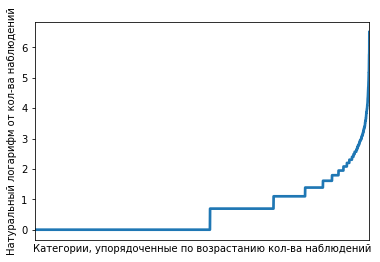

#2
1.3236203444406565
4055 4055


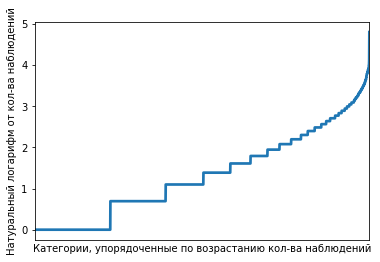

#3
3.3946857410955125
127 127


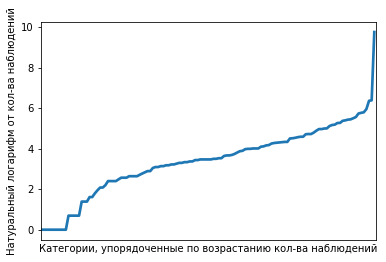

#4
3.283774099640439
176 176


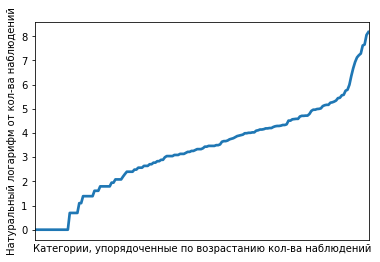

#5
3.0780453152863863
444 444


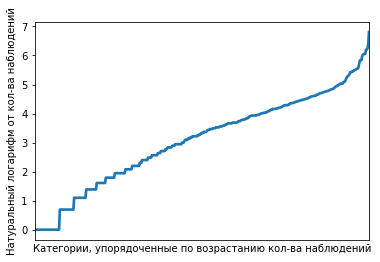

#6
2.770897890745429
332 332


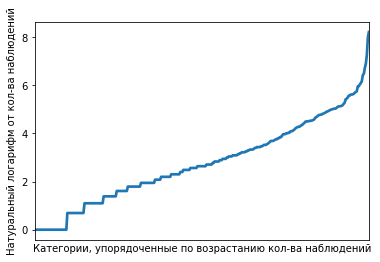

#7
1.1970226017462675
2213 2213


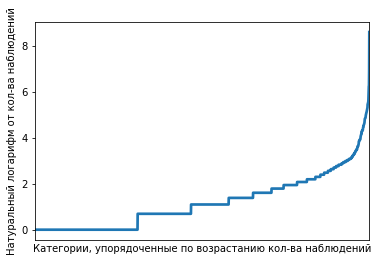

#8
4.007138607765825
67 67


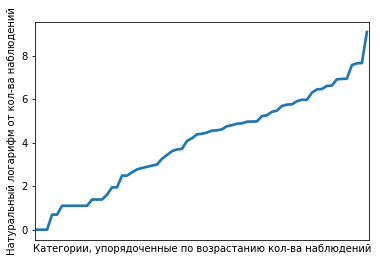

#9
2.770897890745429
332 332


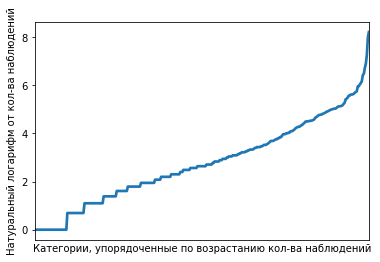

mean_cat_size: 2.495933462701883
adult
Overall features: 15; Categ features: 8
#2
6.552120432710689
8 8


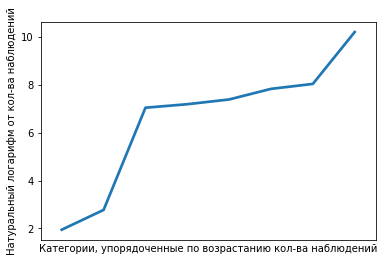

#4
6.953377366744785
16 16


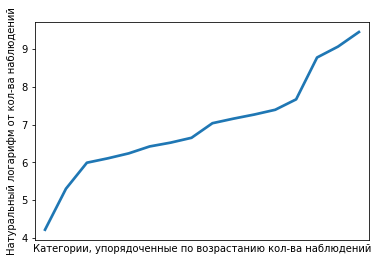

#6
7.376602053673636
7 7


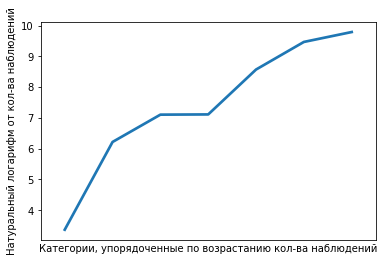

#7
7.282783467408772
14 14


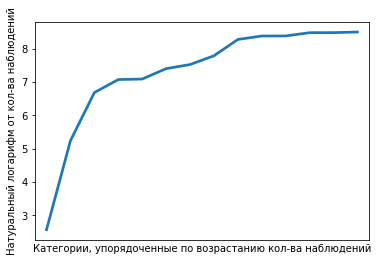

#8
8.425397462951672
6 6


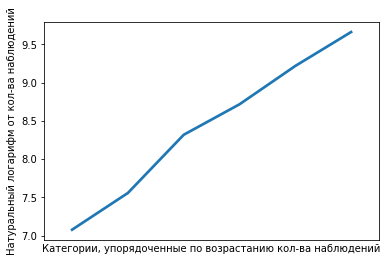

#9
7.496980000665445
5 5


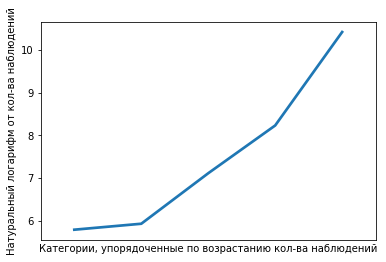

#10
9.820274110020954
2 2


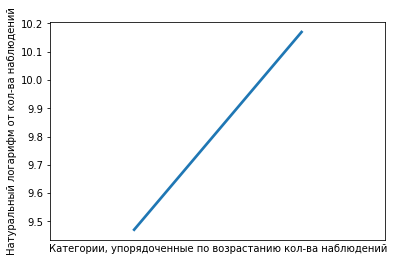

#14
4.0731486761526146
41 41


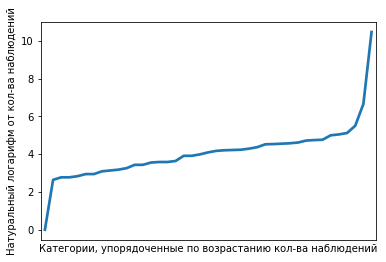

mean_cat_size: 7.247585446291072
appet
Overall features: 420; Categ features: 38
#191
6.741700694652055
1 1


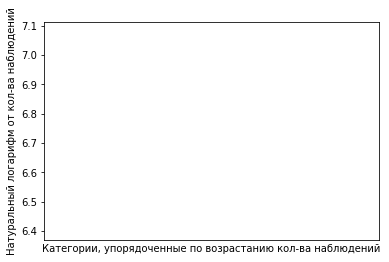

#192
3.5163098101575443
352 352


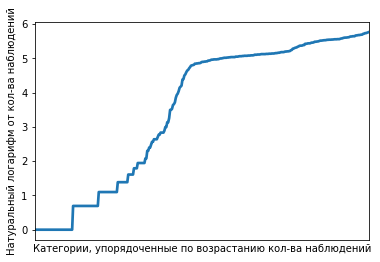

#193
3.3356499899383
49 49


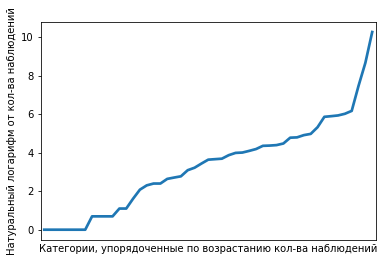

#194
5.895998914227469
3 3


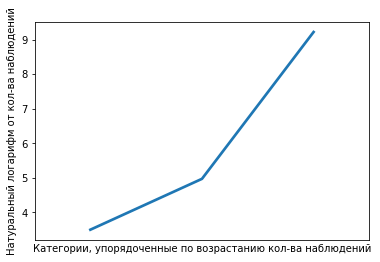

#195
2.803056010228602
23 23


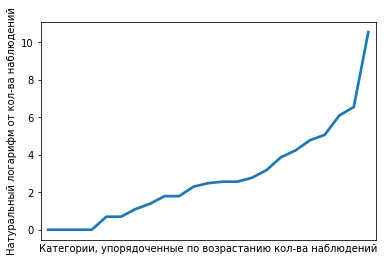

#196
4.718755641216369
4 4


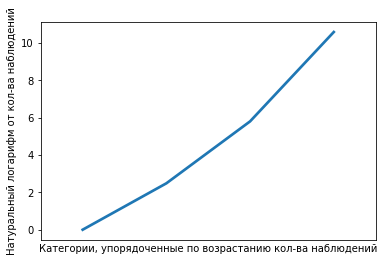

#197
3.6119568784433405
219 219


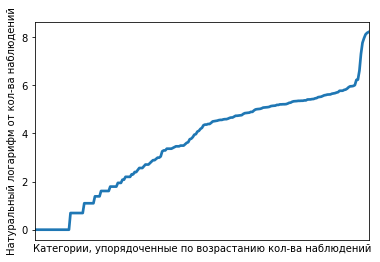

#198
1.1135260777662699
3884 3884


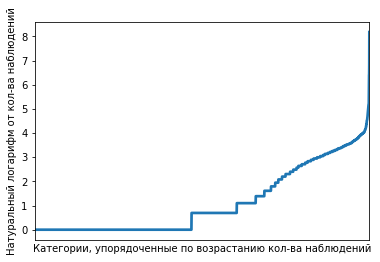

#199
0.6524069149873084
4370 4370


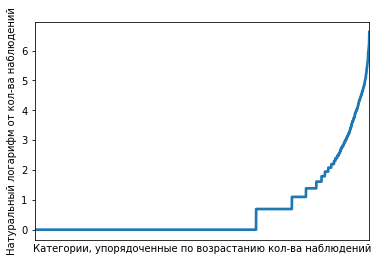

#200
0.27087377979607147
13344 13344


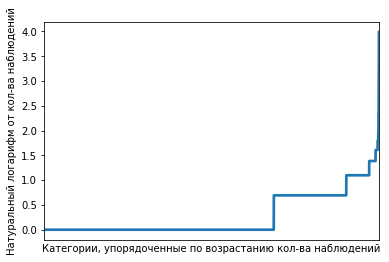

#201
5.423939857260579
2 2


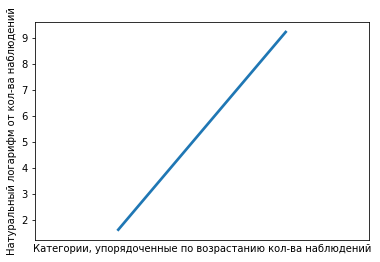

#202
1.4845395027914088
5510 5510


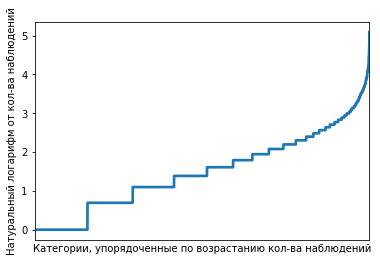

#203
6.622696694316378
4 4


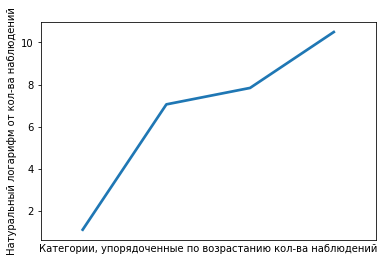

#204
5.748076998284855
100 100


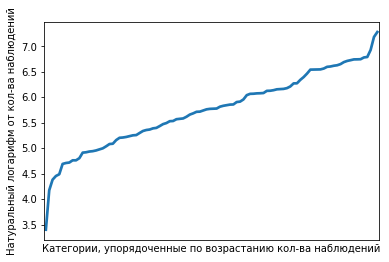

#205
9.15778507037671
3 3


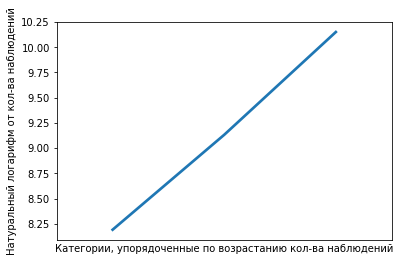

#206
6.3765600930228326
21 21


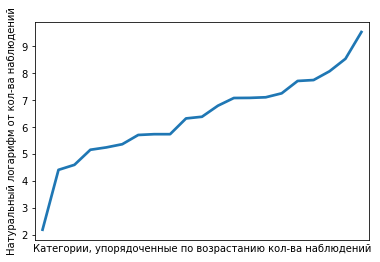

#207
5.151650681337477
13 13


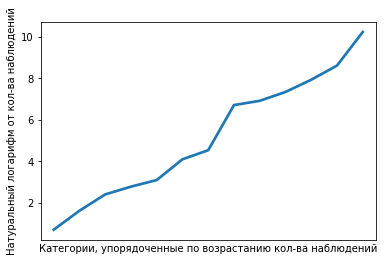

#208
9.271411014314717
2 2


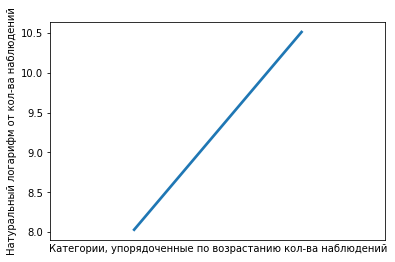

#210
6.239896783609354
6 6


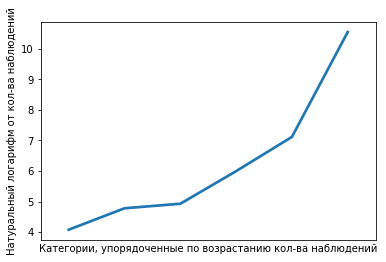

#211
9.672639944586773
2 2


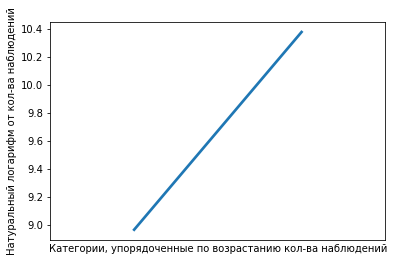

#212
3.320096859013822
79 79


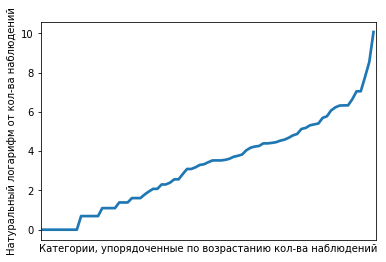

#213
6.813444599510896
1 1


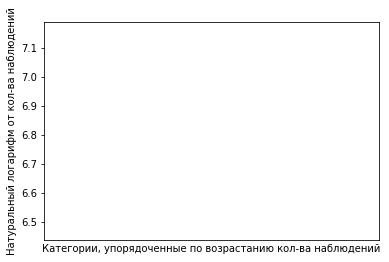

#214
0.27087377979607147
13344 13344


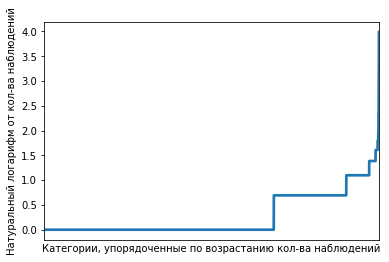

#215
6.3080984415095305
1 1


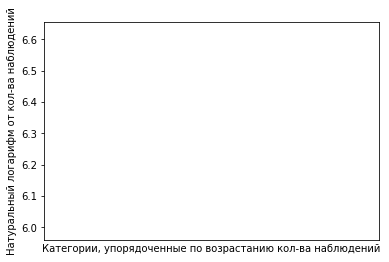

#216
1.062860402798542
1826 1826


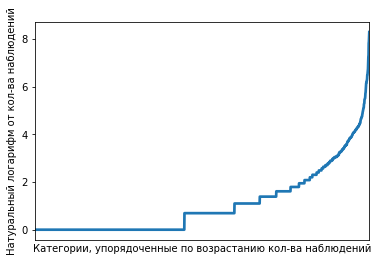

#217
0.6097039297842564
12442 12442


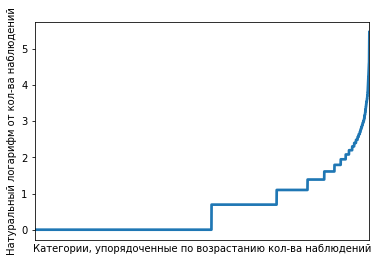

#218
9.88898470644357
2 2


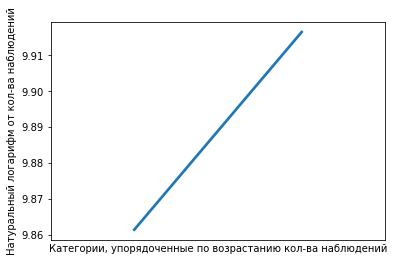

#219
3.1718156282730763
22 22


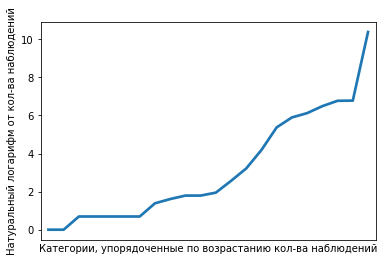

#220
1.1135260777662699
3884 3884


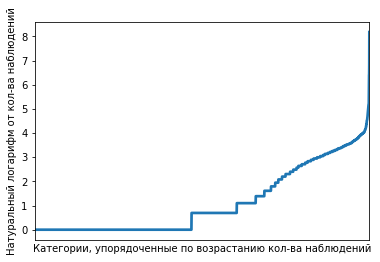

#221
7.295502232334504
7 7


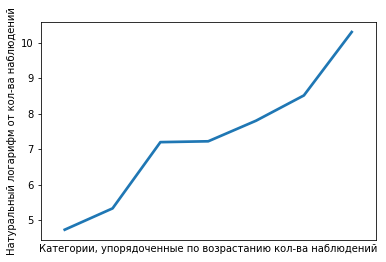

#222
1.1135260777662699
3884 3884


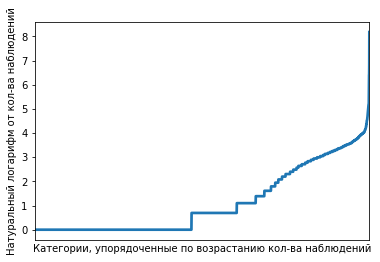

#223
7.751117092907172
4 4


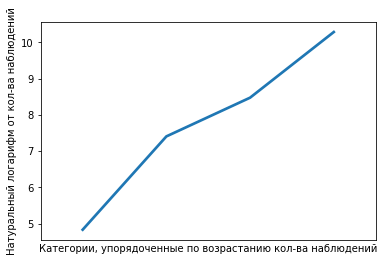

#224
6.499787040655854
1 1


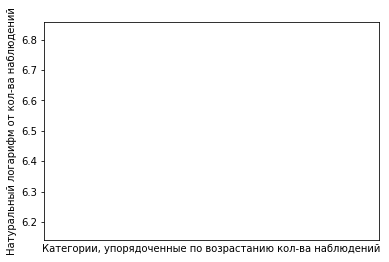

#225
8.55979413897124
3 3


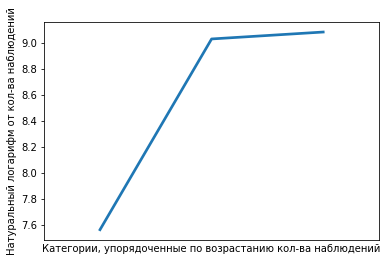

#226
7.2374872045859515
23 23


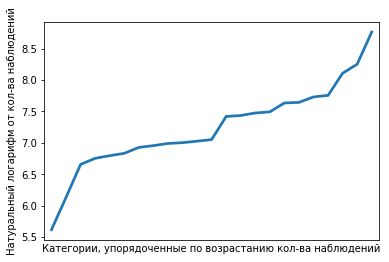

#227
7.263341010838626
7 7


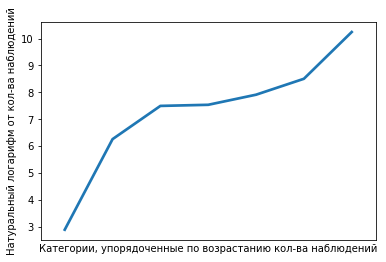

#228
4.7713215102485815
29 29


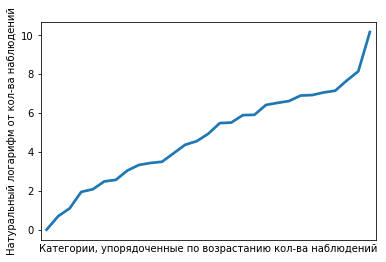

#229
6.258997704874189
4 4


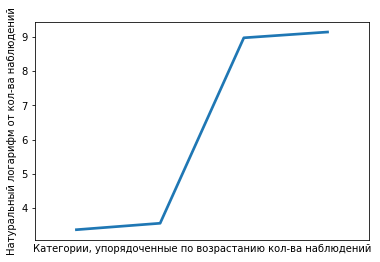

mean_cat_size: 4.924202889194549
kick
Overall features: 44; Categ features: 23
#1
9.76634685538492
3 3


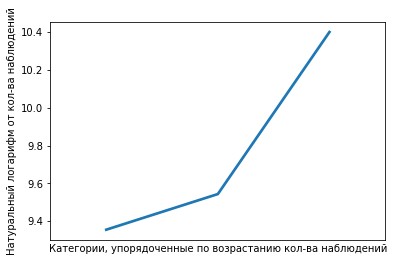

#2
7.5648955833858125
10 10


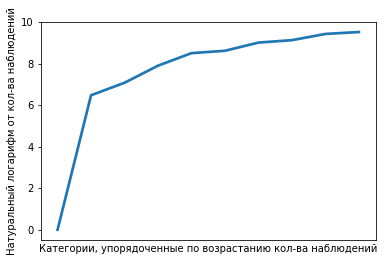

#4
5.480010850157053
33 33


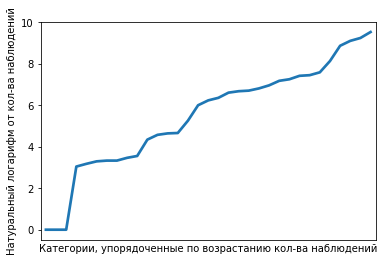

#5
2.3231177121314346
1021 1021


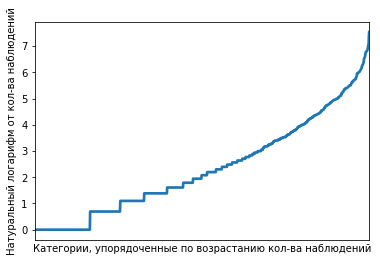

#6
3.591554166425099
133 133


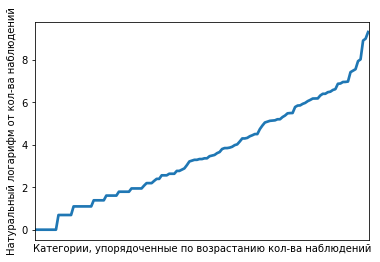

#7
2.1917409332559403
823 823


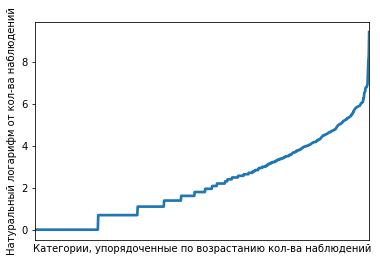

#8
7.289026556265836
16 16


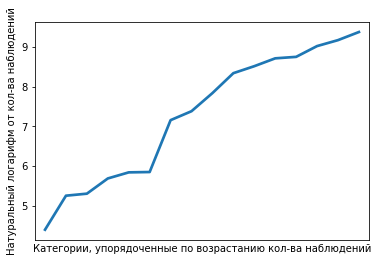

#9
9.28464200406987
2 2


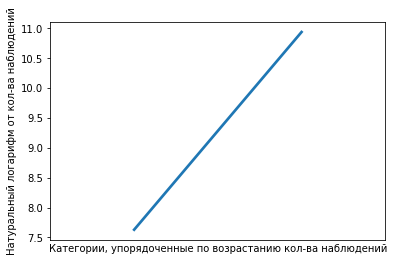

#10
7.119085155726127
4 4


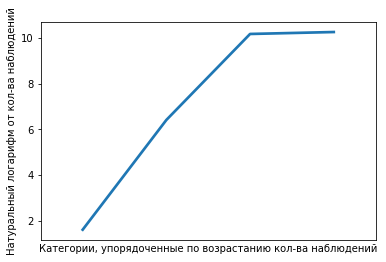

#11
8.955634236823471
3 3


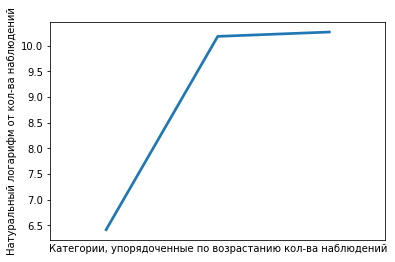

#13
8.156670054471963
4 4


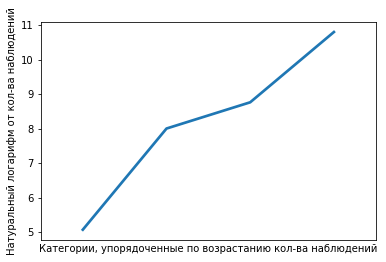

#14
7.901396125651208
12 12


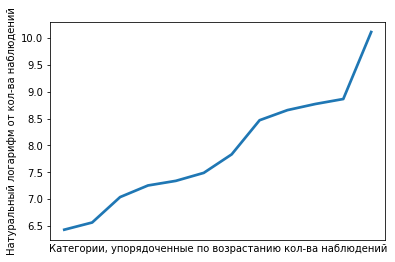

#15
9.527817372539877
4 4


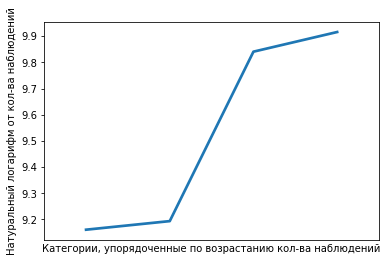

#24
5.782099129573826
2 2


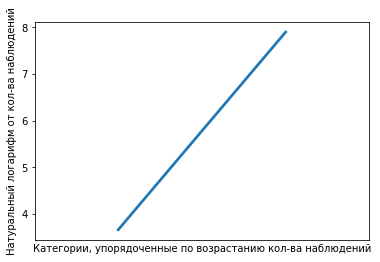

#25
6.061782827000892
2 2


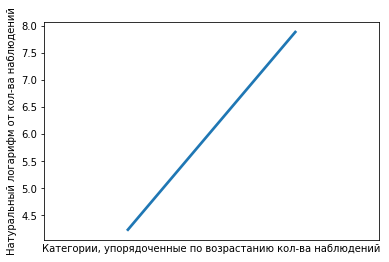

#26
4.926443000567331
74 74


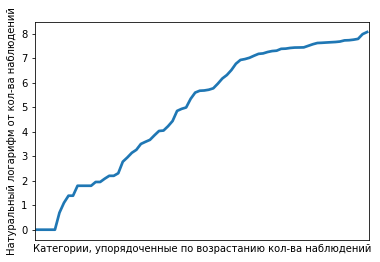

#27
4.718846057702845
153 153


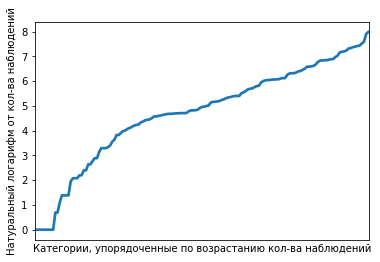

#28
6.021762452977843
37 37


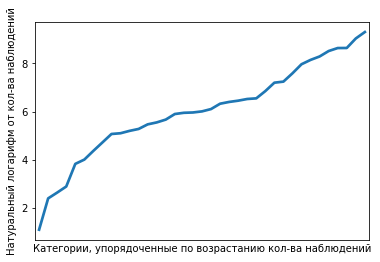

#30
9.127446538975775
2 2


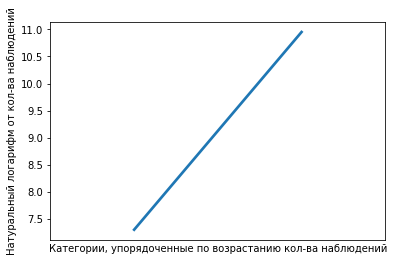

#32
10.280902347426524
2 2


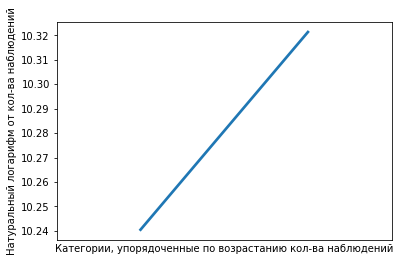

#33
8.484277507076369
12 12


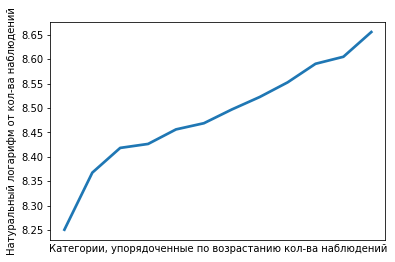

#34
7.514557876578863
31 31


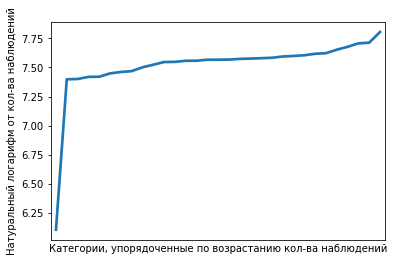

#35
7.0800536406968195
7 7


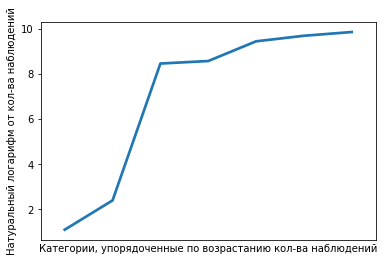

mean_cat_size: 6.919569955863727


In [30]:
for dir_ in dir_datasets:
    print(dir_)
    dataset_full_path = os.path.join(dir_, file_name)
    cur_dataset = pd.read_csv(dataset_full_path, header=None, delimiter='\t')
    description_full_path = os.path.join(dir_, cd_file_name)
    cat_nums, target_num = split_feature_nums(description_full_path)
    print('Overall features: {}; Categ features: {}'.format(cur_dataset.shape[1], len(cat_nums)))
    cur_dataset.iloc[:, target_num] = cur_dataset.iloc[:, target_num].replace(-1, 0)
    m_sizes = []
    for num in cat_nums:
        print('#{}'.format(num))
        col_name = cur_dataset.columns[num]
        local_dataset = cur_dataset.iloc[:, [num, target_num]]
        if local_dataset.iloc[:, 0].dtype == 'object' or local_dataset.iloc[:, 0].dtype == 'str':
            local_dataset = (local_dataset[local_dataset.iloc[:, 0] != '?'])

        cnt_1 = local_dataset.groupby(col_name).count()
        x = list(range(cnt_1.shape[0]))
#         print(x)
        y = np.log(cnt_1.sort_values(by=0).values[:, 0])
        m_sizes.append(np.mean(y))
        print(m_sizes[-1])
        print(len(x), len(y))
        ax = sns.pointplot(x=x, y=y, markers='')
        ax.axes.get_xaxis().set_ticks([])
        ax.set(xlabel='Категории, упорядоченные по возрастанию кол-ва наблюдений', ylabel='Натуральный логарифм от кол-ва наблюдений')
        plt.show()
    print('mean_cat_size: {}'.format(sum(m_sizes)/len(m_sizes)))

In [78]:
for dir_ in dir_datasets[:1]:
    print(dir_)
    dataset_full_path = os.path.join(dir_, file_name)
    cur_dataset = pd.read_csv(dataset_full_path, header=None, delimiter='\t')
    description_full_path = os.path.join(dir_, cd_file_name)
    cat_nums, target_num = split_feature_nums(description_full_path)
    print('Overall features: {}; Categ features: {}'.format(cur_dataset.shape[1], len(cat_nums)))
    cur_dataset.iloc[:, target_num] = cur_dataset.iloc[:, target_num].replace(-1, 0)
    for num in cat_nums:
        print('#{}'.format(num))
        col_name = cur_dataset.columns[num]
        local_dataset = cur_dataset.iloc[:, [num, target_num]]
        if local_dataset.iloc[:, 0].dtype == 'object' or local_dataset.iloc[:, 0].dtype == 'str':
            local_dataset = (local_dataset[local_dataset.iloc[:, 0] != '?'])
#         print(local_dataset.iloc[:, 0].value_counts())
        thetas = local_dataset.groupby(col_name).mean() 
#         print(thetas)
        print('count of 1: {}'.format((thetas == 1).sum()[0]))
        print('count of 0: {}'.format((thetas == 0).sum()[0]))
        print()
        lens = local_dataset.groupby(col_name).count()
        cnt_1 = local_dataset.groupby(col_name).sum()
        
        cnt = thetas.shape[0]
        mean_thetas = thetas.mean()
        var_thetas = cnt*np.var(thetas)/(cnt - 1)

        print('MEAN')
#         alpha = mean_thetas*(mean_thetas*(1 - mean_thetas)/(var_thetas*var_thetas) - 1)
#         beta = (1 - mean_thetas)*(mean_thetas*(1 - mean_thetas)/(var_thetas*var_thetas) - 1)
        alpha = local_dataset[target_num].mean() 
        beta = 1 - alpha
        print(alpha, beta)

        alpha = [10]
        beta = [10]

        print('NEW')
        alpha_new, beta_new, p_new = get_approx_newton(lens.iloc[:, 0], cnt_1.iloc[:, 0], alpha[0], beta[0])
        print('GD')
        alpha_gd, beta_gd, p_gd = get_approx_gd(lens.iloc[:, 0], cnt_1.iloc[:, 0], alpha[0], beta[0], init_step=0.005)
        print()
        print('alpha_new: {}, beta_new: {}, log p: {}'.format(alpha_new, beta_new, p_new))
        print()
        
#         x = []
#         y_gd = []
#         y_mix = []
#         y_new = []
        x = np.random.beta(alpha_new, beta_new, size=300).T
#         for i in np.arange(0.0, 1.000001, 0.01):
#             x.append(i)
#             y_gd.append(scipy.stats.beta.pdf(i, alpha_gd, beta_gd))
            
#             y_mix.append(q*scipy.stats.beta.pdf(i, alpha_mix1, beta_mix1) + (1 - q)*scipy.stats.beta.pdf(i, alpha_mix2, beta_mix2))
#             y_new.append(scipy.stats.beta.pdf(i, alpha_new, beta_new))
            
#         sns.pointplot(x=x, y=y_gd, markers=[''])#,
#             go.Scatter(x=x, y=y_mix, mode='lines', name='mix'),
        fig, ax = plt.subplots()
        sns.distplot(thetas.iloc[:, 0], kde=False, color='red', ax=ax, norm_hist=True)
        sns.kdeplot(x)
        plt.show()


amazon
Overall features: 10; Categ features: 9
#1
count of 1: 5761
count of 0: 259

MEAN
0.9421323669654778 0.05786763303452225
NEW


/usr/local/lib/python3.6/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning:

Method TNC does not use Hessian information (hess).

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: OptimizeWarning:

Unknown solver options: iprint



Initial values: alpha=10	beta=10	score=-13415.056317931681
Optimization result: alpha=14.831671335903273	beta=0.9927296809395472	score=5612.520376967501	success=False
Use optimized values
GD
step = 0
alpha = 10, beta = 10
alpha_ans = 10, beta_ans= 10
score: -13415.056317931681
step = 100
alpha = 23.04368577044842, beta = 1.1352025856405192
alpha_ans = 20.79711775418404, beta_ans= 1.3000755746014026
score: -5652.749451008479
step = 200
alpha = 23.900733964921905, beta = 1.285449547726317
alpha_ans = 20.79711775418404, beta_ans= 1.3000755746014026
score: -5635.080834967451
step = 300
alpha = 24.076754309945176, beta = 1.3336751641641815
alpha_ans = 20.79711775418404, beta_ans= 1.3000755746014026
score: -5630.516510247415
step = 400
alpha = 24.11211882206502, beta = 1.3454722366086138
alpha_ans = 20.79711775418404, beta_ans= 1.3000755746014026
score: -5629.49152493099
step = 500
alpha = 24.118868237831855, beta = 1.347862995571662
alpha_ans = 20.79711775418404, beta_ans= 1.300075574601402

KeyboardInterrupt: 

# Check on correctness

In [88]:
alpha = 5
beta = 8

theta_sample = np.random.beta(alpha, beta, 20)
lens = np.random.randint(20, 500, 20)
cnt1 = np.zeros((20,))
for i, len_ in enumerate(lens):
    cnt1[i] = (np.random.uniform(0.0, 1.0, len_) < theta_sample[i]).sum()
print(theta_sample)
print(lens)
print(cnt1)

iplot([go.Histogram(x=cnt1/lens), go.Scatter(x=np.arange(0.0, 1.0, 0.01), y=scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha, beta), mode='lines')])

[ 0.40653204  0.34961176  0.46491935  0.31882325  0.34119647  0.29821222
  0.377111    0.60686772  0.28695476  0.36738971  0.34885444  0.5880459
  0.36929978  0.36883289  0.49512299  0.23709243  0.42995269  0.45685582
  0.45321398  0.6455889 ]
[ 97 411 412 394  51 359 499  74 277 124 248 354 495 209 324  28  71 275
 349 264]
[  46.  155.  201.  117.   21.   99.  166.   42.   73.   40.   77.  219.
  176.   84.  148.    6.   31.  115.  166.  162.]


In [91]:
thetas = cnt1/lens
cnt = thetas.shape[0]
mean_thetas = thetas.mean()
var_thetas = cnt*np.var(thetas)/(cnt - 1)

alpha_init = mean_thetas*(mean_thetas*(1 - mean_thetas)/(var_thetas*var_thetas) - 1)
beta_init = (1 - mean_thetas)*(mean_thetas*(1 - mean_thetas)/(var_thetas*var_thetas) - 1)

alpha_gd, beta_gd, p = get_approx_gd(lens, cnt1, alpha_init, beta_init)
print(alpha_gd, beta_gd)

step = 0
alpha = 587.2255899240362, beta = 860.60278815256
alpha_ans = 587.2255899240362, beta_ans= 860.60278815256
score: -3563.691120665404
step = 100
alpha = 585.0909834048379, beta = 860.1400709824532
alpha_ans = 585.1098320827532, beta_ans= 860.1464303362559
score: -3563.643101495254
step = 200
alpha = 583.3967820435084, beta = 859.371687442731
alpha_ans = 583.4121083354623, beta_ans= 859.3804955017633
score: -3563.608362638828
step = 300
alpha = 581.9871402083501, beta = 858.4048610701807
alpha_ans = 582.0001959405316, beta_ans= 858.4152598988649
score: -3563.5790890548233
step = 400
alpha = 580.760545907034, beta = 857.3089826126227
alpha_ans = 580.7721446044228, beta_ans= 857.3204175317483
score: -3563.5520110903162
step = 500
alpha = 579.6511387376337, beta = 856.1288789116702
alpha_ans = 579.6618073106346, beta_ans= 856.1409919145686
score: -3563.525767019717
step = 600
alpha = 578.6163155391007, beta = 854.893460645214
alpha_ans = 578.6263943815667, beta_ans= 854.90602103471

In [73]:
print(alpha_gd, beta_gd)

6.50713605383 8.93599708749


In [92]:
alpha_test = 0.165
beta_test = 22.623
var_eps = 0.01
new_exp = calc_exp(alpha_test, beta_test)
print('exp = {}'.format(new_exp))
beta_exp = (new_exp*(1 - new_exp)*(1 - new_exp))/var_eps - (1 - new_exp)
alpha_exp = (new_exp/(1 - new_exp))*beta_exp
print(calc_var(alpha_test, beta_test))
print('alpha = {}; beta = {}'.format(alpha_exp, beta_exp))
var = calc_var(alpha_exp, beta_exp)
print(var)

exp = 0.007240652975250132
0.00030217865813612465
alpha = -0.002035908035995032; beta = -0.27914149998979154
0.01


In [93]:
alpha_new, beta_new, p = get_approx_newton(lens, cnt1, 0.5, 0.5)

step = 0
alpha = 0.5, beta = 0.5
alpha_ans = 0.5, beta_ans= 0.5
score: -3517.1789780600793
0
alpha = 9.90210611896147, beta = 14.370578207516921
score: -3492.7755457840244
after_matrix
after_coeff
step
1
alpha = 9.316207483896486, beta = 13.505210560646123
score: -3492.7622202904076
after_matrix
after_coeff
step
2
alpha = 9.356085215601613, beta = 13.56404001075171
score: -3492.762144383457
after_matrix
after_coeff
step
3
alpha = 9.356296941575486, beta = 13.564351957197315
score: -3492.762144381363
after_matrix
after_coeff
step
4
alpha = 9.356296947483697, beta = 13.564351965891646
score: -3492.76214438136
after_matrix
after_coeff
step
5
alpha = 9.356296947483697, beta = 13.564351965891646
score: -3492.76214438136
after_matrix
after_coeff
step
6
alpha = 9.356296947483697, beta = 13.564351965891646
score: -3492.76214438136
after_matrix
after_coeff
step
7
alpha = 9.356296947483697, beta = 13.564351965891646
score: -3492.76214438136
after_matrix
after_coeff
step
8
alpha = 9.3562969474836

In [94]:
print(alpha_new, beta_new)

9.35629694748 13.5643519659


In [70]:
iplot([go.Histogram(x=cnt1/lens), 
       go.Scatter(x=np.arange(0.0, 1.0, 0.01), y=scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha, beta), mode='lines', name='real'),
       go.Scatter(x=np.arange(0.0, 1.0, 0.01), y=scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha_gd, beta_gd), mode='lines', name='gd'),
       go.Scatter(x=np.arange(0.0, 1.0, 0.01), y=scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha_new, beta_new), mode='lines', name='new')
      ])

In [50]:
q, alpha1, beta1, alpha2, beta2 = 0.3, 2, 3, 10, 30
sample_q = np.random.uniform(0, 1, 20)
sample = np.zeros(20)
cnt_1 = (sample_q < q).sum()
sample[:cnt_1] = np.random.beta(alpha1, beta1, cnt_1)
sample[cnt_1:] = np.random.beta(alpha2, beta2, 20 - cnt_1)
lens = np.random.randint(20, 500, 20)
cnt_1 = np.zeros((20,))

for i, theta in enumerate(sample):
    cnt_1[i] = (np.random.uniform(0.0, 1.0, lens[i]) < theta).sum()

x = []
y = []
for i in np.arange(0.0, 1.0, 0.001):
    x.append(i)
    y.append(q*scipy.stats.beta.pdf(i, alpha1, beta1) + (1 - q)*scipy.stats.beta.pdf(i, alpha2, beta2))

iplot([go.Histogram(x=cnt_1/lens), go.Scatter(x=x, y=y, mode='lines')])

In [66]:
thetas = np.sort(cnt_1/lens)
mean_thetas1 = thetas[:cnt//2].mean()
var_thetas1 = np.var(thetas[:cnt//2], ddof=1)

mean_thetas2 = thetas[cnt//2:].mean()
var_thetas2 = np.var(thetas[cnt//2:], ddof=1)

alpha1_init = mean_thetas1*(mean_thetas1*(1 - mean_thetas1)/(var_thetas1*var_thetas1) - 1)/100
beta1_init = (1 - mean_thetas1)*(mean_thetas1*(1 - mean_thetas1)/(var_thetas1*var_thetas1) - 1)/100

alpha2_init = mean_thetas2*(mean_thetas2*(1 - mean_thetas2)/(var_thetas2*var_thetas2) - 1)/10
beta2_init = (1 - mean_thetas2)*(mean_thetas2*(1 - mean_thetas2)/(var_thetas2*var_thetas2) - 1)/100


q_gd, alpha1_gd, beta1_gd, alpha2_gd, beta2_gd, p_gd = get_approx_mix_gd(lens, cnt_1, alpha1_init, beta1_init, alpha2_init, beta2_init)

0.5
121.929458377 429.288318753
25.4960728903 3.20264903236
score: -3758.527639067296
der: 0.29225243693935, -0.09681179491157366, -2.7007957136247356, 8.673791320067838
0.705472895022
122.221710814 429.191506958
22.7952771767 11.8764403524
score: -3803.670009309406
der: 0.2552407442385629, -0.08521560461250033, -1.1387873444448289, 1.6907433073272333
0.699336188665
122.476951558 429.106291353
21.6564898323 13.5671836598
score: -3796.046291779855
der: 0.24065885311833313, -0.08106448380243592, -0.8053242767714757, 1.0427499965791434
0.696677764201
122.717610412 429.02522687
20.8511655555 14.6099336563
score: -3788.9138537541567
der: 0.22174646925586217, -0.07555346855382084, -0.6096271496623125, 0.701970565949491
0.691956465986
122.939356881 428.949673401
20.2415384058 15.3119042223
score: -3782.3155655955097
der: 0.20064173240814398, -0.06933005305351969, -0.488456189563788, 0.49856552899224127
0.685969854846
123.139998613 428.880343348
19.7530822163 15.8104697513
score: -3776.1768509

122.004678709 428.680635266
8.02525879262 10.733514431
score: -3456.4719372531717
der: -0.07819610802522448, 0.017190847353262484, -0.2165630619937673, -0.1677943463431646
0.473041482953
121.926482601 428.697826113
7.80869573063 10.5657200847
score: -3449.677296792107
der: -0.07638929975411202, 0.016831779271761604, -0.2219309927054951, -0.1714009390214315
0.465398064045
121.850093301 428.714657892
7.58676473792 10.3943191456
score: -3442.7018635043564
der: -0.07405424527075155, 0.01633633297053194, -0.2274672007479417, -0.17538992469197012
0.457062054954
121.776039056 428.730994225
7.35929753717 10.218929221
score: -3435.5359245263176
der: -0.0711217705429803, 0.01568639651090109, -0.2329512188471874, -0.1798247245759832
0.447955328909
121.704917285 428.746680622
7.12634631833 10.0391044964
score: -3428.174552750349
der: -0.06752908320881801, 0.014865317552917645, -0.2380314239319432, -0.18476642990130188
0.43800930204
121.637388202 428.761545939
6.88831489439 9.85433806648
score: -34

3.7870704322 7.48126864105
score: -3325.625127264555
der: 0.02424759899440687, -0.008775281155088521, 1.6977911050915004, -1.1082769053952148
0.325713986259
120.892897684 428.715566567
5.4848615373 6.37299173566
score: -3353.247041442416
der: -0.05087678861251277, 0.01069879970837917, -1.6754169179360794, 1.1109848470385302
0.409582272663
120.842020896 428.726265367
3.80944461936 7.48397658269
score: -3326.217325857063
der: 0.02347606982722894, -0.008578689773145243, 1.651385178937936, -1.088354016549026
0.327013034445
120.865496966 428.717686677
5.4608297983 6.39562256614
score: -3352.9260938641105
der: -0.049886734352114104, 0.010453079123877274, -1.6467885530419792, 1.0800443816907688
0.407763649666
120.815610231 428.728139756
3.81404124526 7.47566694784
score: -3326.192657269774
der: 0.023137158407120495, -0.008476296670814065, 1.6274161492786057, -1.076020501752172
0.326360203507
120.83874739 428.719663459
5.44145739453 6.39964644608
score: -3352.490025111275
der: -0.0492649276051

3.85361950741 7.49096675085
score: -3327.0706310806772
der: 0.020430291124974076, -0.007674829189710408, 1.5952642430320267, -1.0502417939325994
0.323515043094
119.12465501 428.820125697
5.44888375044 6.44072495692
score: -3352.9452404876884
der: -0.04341412094855457, 0.00861973813427852, -1.5945316197154895, 1.0505932346570042
0.401834667
119.081240889 428.828745436
3.85435213073 7.49131819157
score: -3327.0885632046347
der: 0.02039395012440437, -0.007664165074501739, 1.5945125725798022, -1.0497659566550546
0.323481420886
119.101634839 428.821081271
5.44886470331 6.44155223492
score: -3352.951171895152
der: -0.04331840450289093, 0.008593095155092101, -1.5937810838736226, 1.0501204989952235
0.401758403045
119.058316434 428.829674366
3.85508361943 7.49167273391
score: -3327.10649915289
der: 0.02035787719349358, -0.007653575128742318, 1.5937647537312998, -1.0492924932235574
0.323447749782
119.078674312 428.822020791
5.44884837316 6.44238024069
score: -3352.957171834602
der: -0.0432227093

In [67]:
print(q_gd, alpha1_gd, beta1_gd, alpha2_gd, beta2_gd, p_gd)

0.324202879841 121.521199614 428.724621509 2.37779584654 6.64125898191 -3281.98248215


In [68]:
q_new, alpha1_new, beta1_new, alpha2_new, beta2_new, p_new = get_approx_mix_newton(lens, cnt_1, alpha1_init, beta1_init, alpha2_init, beta2_init)

q = 0.5
alpha1 = 121.92945837730194, beta1 = 429.2883187530203
alpha2 = 25.49607289032118, beta2 = 3.2026490323649983
score: -3758.527639067296
der: 0.29225243693935, -0.09681179491157366, -2.7007957136247356, 8.673791320067838
[-122.30931927 -423.16448212 -266.83230883  -31.0204457 ]
!!!!!!!!!! Change for 1
var before: 0.0002681357562356067
after: alpha=3.6016977235591705; beta=12.649288198413688
var after: 0.009999999999999997
----------
!!!!!!!!!! Change for 2
var before: 0.0012010693832294635
after: alpha = 7.631754771274395; beta = 0.9132094445190356
var after: 0.009999999999999998
----------
q = 0.7054728950217471
alpha1 = 3.6016977235591705, beta1 = 12.649288198413688
alpha2 = 7.631754771274395, beta2 = 0.9132094445190356
score: -3366.4497412848027
der: 5.688794904251978, -1.6931032366861842, -0.7202383920460864, 3.849729971770004
[  0.32892794   6.74719489  37.23580352   1.56979113]
q = 0.8902496282418526
alpha1 = 3.5679896097732304, beta1 = 11.957844319866185
alpha2 = 3.815877

der: 0.2804815893751531, 0.03702661663285767, 0.0001890726546385224, 0.0005258208176899259
[-1.32429902 -3.43111269 -0.06477627 -0.04680715]
!!!!!!!!!! Change for 1
var before: 0.008086229804594
after: alpha=5.31730405511286; beta=13.77603079506978
var after: 0.01
----------
!!!!!!!!!! Change for 2
var before: 0.009954388794992431
after: alpha = 13.569558754271293; beta = 9.766444886005258
var after: 0.009999999999999998
----------
q = 0.8211915404828508
alpha1 = 5.31730405511286, beta1 = 13.77603079506978
alpha2 = 13.569558754271293, beta2 = 9.766444886005258
score: -3541.5234522728547
der: 0.280540280437382, 0.03701612073353999, 0.0001947510390341023, 0.000513958883609611
[-1.32439169 -3.43134553 -0.06448691 -0.0465542 ]
!!!!!!!!!! Change for 1
var before: 0.008086125654797651
after: alpha=5.317259405814543; beta=13.776012510940237
var after: 0.010000000000000002
----------
!!!!!!!!!! Change for 2
var before: 0.0099546022182953
after: alpha = 13.569510321778779; beta = 9.766550267660

after: alpha=5.317121353416468; beta=13.775955974590108
var after: 0.01
----------
!!!!!!!!!! Change for 2
var before: 0.009955262127391899
after: alpha = 13.569360578795555; beta = 9.766876056393818
var after: 0.010000000000000002
----------
q = 0.8211694257915743
alpha1 = 5.317121353416468, beta1 = 13.775955974590108
alpha2 = 13.569360578795555, beta2 = 9.766876056393818
score: -3541.520459918694
der: 0.2807217688967967, 0.03698366112435281, 0.0002123055539673402, 0.00047728876943864407
[-1.32467817 -3.43206539 -0.06359231 -0.04577211]
!!!!!!!!!! Change for 1
var before: 0.008085803681569265
after: alpha=5.31712135307112; beta=13.775955974448674
var after: 0.01
----------
!!!!!!!!!! Change for 2
var before: 0.009955262129043138
after: alpha = 13.56936057842096; beta = 9.766876057208751
var after: 0.010000000000000004
----------
q = 0.8211694257497746
alpha1 = 5.31712135307112, beta1 = 13.775955974448674
alpha2 = 13.56936057842096, beta2 = 9.766876057208751
score: -3541.5204599130375


q = 0.8211694256205528
alpha1 = 5.317121352003544, beta1 = 13.775955974011453
alpha2 = 13.56936057726302, beta2 = 9.766876059727858
score: -3541.5204598955506
der: 0.28072177030041345, 0.03698366087326832, 0.00021230568972896435, 0.0004772884858654791
[-1.32467817 -3.4320654  -0.0635923  -0.0457721 ]
!!!!!!!!!! Change for 1
var before: 0.008085803679079887
after: alpha=5.317121352003526; beta=13.775955974011442
var after: 0.010000000000000002
----------
!!!!!!!!!! Change for 2
var before: 0.00995526213414629
after: alpha = 13.569360577263021; beta = 9.766876059727863
var after: 0.01
----------
q = 0.8211694256205532
alpha1 = 5.317121352003526, beta1 = 13.775955974011442
alpha2 = 13.569360577263021, beta2 = 9.766876059727863
score: -3541.52045989555
der: 0.280721770300449, 0.036983660873261215, 0.0002123056897183062, 0.0004772884858823545
[-1.32467817 -3.4320654  -0.0635923  -0.0457721 ]
!!!!!!!!!! Change for 1
var before: 0.008085803679079864
after: alpha=5.317121352003521; beta=13.775

var after: 0.010000000000000002
----------
!!!!!!!!!! Change for 2
var before: 0.009955262134145553
after: alpha = 13.569360577263048; beta = 9.766876059727801
var after: 0.010000000000000002
----------
q = 0.8211694256205571
alpha1 = 5.317121352003557, beta1 = 13.775955974011458
alpha2 = 13.569360577263048, beta2 = 9.766876059727801
score: -3541.520459895555
der: 0.2807217703004383, 0.03698366087328253, 0.00021230568972896435, 0.00047728848586992
[-1.32467817 -3.4320654  -0.0635923  -0.0457721 ]
!!!!!!!!!! Change for 1
var before: 0.00808580367907963
after: alpha=5.317121352003531; beta=13.775955974011447
var after: 0.01
----------
!!!!!!!!!! Change for 2
var before: 0.009955262134146034
after: alpha = 13.569360577263044; beta = 9.766876059727808
var after: 0.009999999999999997
----------
q = 0.8211694256205555
alpha1 = 5.317121352003531, beta1 = 13.775955974011447
alpha2 = 13.569360577263044, beta2 = 9.766876059727808
score: -3541.5204598955515
der: 0.2807217703004703, 0.036983660873

!!!!!!!!!! Change for 1
var before: 0.00808580367908067
after: alpha=5.317121352003748; beta=13.775955974011532
var after: 0.010000000000000002
----------
!!!!!!!!!! Change for 2
var before: 0.00995526213414516
after: alpha = 13.569360577263213; beta = 9.766876059727444
var after: 0.010000000000000002
----------
q = 0.8211694256205825
alpha1 = 5.317121352003748, beta1 = 13.775955974011532
alpha2 = 13.569360577263213, beta2 = 9.766876059727444
score: -3541.520459895557
der: 0.2807217703000937, 0.036983660873339375, 0.00021230568967567365, 0.0004772884859685078
[-1.32467817 -3.4320654  -0.0635923  -0.0457721 ]
!!!!!!!!!! Change for 1
var before: 0.008085803679080298
after: alpha=5.3171213520036416; beta=13.775955974011495
var after: 0.009999999999999995
----------
!!!!!!!!!! Change for 2
var before: 0.009955262134144766
after: alpha = 13.569360577263069; beta = 9.766876059727755
var after: 0.009999999999999998
----------
q = 0.8211694256205615
alpha1 = 5.3171213520036416, beta1 = 13.7759

----------
!!!!!!!!!! Change for 2
var before: 0.009955262134146003
after: alpha = 13.569360577263017; beta = 9.766876059727874
var after: 0.009999999999999998
----------
q = 0.8211694256205553
alpha1 = 5.317121352003571, beta1 = 13.775955974011465
alpha2 = 13.569360577263017, beta2 = 9.766876059727874
score: -3541.520459895551
der: 0.2807217703002465, 0.03698366087331806, 0.00021230568969521357, 0.000477288485919658
[-1.32467817 -3.4320654  -0.0635923  -0.0457721 ]
!!!!!!!!!! Change for 1
var before: 0.008085803679079979
after: alpha=5.317121352003494; beta=13.775955974011431
var after: 0.010000000000000002
----------
!!!!!!!!!! Change for 2
var before: 0.009955262134145956
after: alpha = 13.569360577262934; beta = 9.766876059728054
var after: 0.009999999999999997
----------
q = 0.8211694256205437
alpha1 = 5.317121352003494, beta1 = 13.775955974011431
alpha2 = 13.569360577262934, beta2 = 9.766876059728054
score: -3541.5204598955493
der: 0.2807217703005165, 0.03698366087321148, 0.00021

der: 0.28072177030049517, 0.0369836608732399, 0.00021230568974495156, 0.00047728848583084016
[-1.32467817 -3.4320654  -0.0635923  -0.0457721 ]
!!!!!!!!!! Change for 1
var before: 0.008085803679079922
after: alpha=5.317121352003437; beta=13.775955974011408
var after: 0.01
----------
!!!!!!!!!! Change for 2
var before: 0.009955262134146964
after: alpha = 13.5693605772629; beta = 9.766876059728116
var after: 0.009999999999999998
----------
q = 0.8211694256205399
alpha1 = 5.317121352003437, beta1 = 13.775955974011408
alpha2 = 13.5693605772629, beta2 = 9.766876059728116
score: -3541.52045989555
der: 0.28072177030048806, 0.036983660873261215, 0.00021230568970942443, 0.00047728848588945993
[-1.32467817 -3.4320654  -0.0635923  -0.0457721 ]
!!!!!!!!!! Change for 1
var before: 0.00808580367907971
after: alpha=5.317121352003434; beta=13.775955974011408
var after: 0.009999999999999998
----------
!!!!!!!!!! Change for 2
var before: 0.009955262134146523
after: alpha = 13.569360577262856; beta = 9.76

In [69]:
print(q_new, alpha1_new, beta1_new, alpha2_new, beta2_new, p_new)

0.89167174748 3.55987046753 9.89323615644 1.90793869282 0.829437779249 -3256.46213965


In [70]:
iplot([go.Histogram(x=cnt_1/lens), 
       go.Scatter(x=np.arange(0.0, 1.0, 0.01), y=q*scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha1, beta1) + (1 - q)*scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha2, beta2), mode='lines', name='real'),
       go.Scatter(x=np.arange(0.0, 1.0, 0.01), y=q_gd*scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha1_gd, beta1_gd) + (1 - q_gd)*scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha2_gd, beta2_gd), mode='lines', name='gd'),
       go.Scatter(x=np.arange(0.0, 1.0, 0.01), y=q_new*scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha1_new, beta1_new) + (1 - q_new)*scipy.stats.beta.pdf(np.arange(0.0, 1.0, 0.01), alpha2_new, beta2_new), mode='lines', name='new')
      ])

# Get datasets with new features

In [34]:
from sklearn.utils import shuffle

In [17]:
class CategToNum:
    def __init__(self, learn_dataset_path, description_path):
        self.learn_dataset_path = learn_dataset_path
        self.description_path = description_path
        
        self.learn_dataset = pd.read_csv(dataset_full_path, header=None, delimiter='\t')
        self.cat_nums, self.target_num = split_feature_nums(description_full_path)
        print('Overall features: {}; Categ features: {}'.format(self.learn_dataset.shape[1], len(self.cat_nums)))
        self.learn_dataset.iloc[:, self.target_num] = self.learn_dataset.iloc[:, self.target_num].replace(-1, 0)
        self.find_params()
        
    def find_params(self):
        self.prior = {}
        self.cnt1 = {}
        self.lens = {}
        for num in self.cat_nums:
            col_name = self.learn_dataset.columns[num]
            local_dataset = self.learn_dataset.iloc[:, [num, self.target_num]]
            if local_dataset.iloc[:, 0].dtype == 'object' or local_dataset.iloc[:, 0].dtype == 'str':
                local_dataset = (local_dataset[local_dataset.iloc[:, 0] != '?'])
            print(local_dataset.iloc[:, 0].value_counts())
            thetas = local_dataset.groupby(col_name).mean() 
            print(thetas)
            print('count of 1: {}'.format((thetas == 1).sum()[0]))
            print()
            lens = local_dataset.groupby(col_name).count()
            cnt_1 = local_dataset.groupby(col_name).sum()

            cnt = thetas.shape[0]
            mean_thetas = thetas.mean()
            var_thetas = cnt*np.var(thetas)/(cnt - 1)

            alpha = min(50, (mean_thetas*(mean_thetas*(1 - mean_thetas)/(var_thetas*var_thetas) - 1))[0])
            beta = min(50, ((1 - mean_thetas)*(mean_thetas*(1 - mean_thetas)/(var_thetas*var_thetas) - 1))[0])

            alpha_new, beta_new, p_new = get_approx_newton(lens.iloc[0], cnt_1.iloc[0], alpha, beta)
            self.prior[num] = (alpha_new, beta_new)
            self.cnt1[num] = cnt_1
            self.lens[num] = lens
            
            print()
            print('alpha_new: {}, beta_new: {}, log p: {}'.format(alpha_new, beta_new, p_new))
            print()
        
    def change_dataset_poor_bayes(self, dataset, alpha, beta):
        new_dataset = dataset.iloc[:, self.cat_nums].copy()
        for num, col_num in enumerate(self.cat_nums):
            new_dataset.iloc[:, num] = self.change_col(col_num, new_dataset.iloc[:, num], alpha, beta)
        return new_dataset        
            
    def change_dataset_smart_bayes(self, dataset):
        new_dataset = dataset.iloc[:, self.cat_nums].copy()
        for num, col_num in enumerate(self.cat_nums):
            new_dataset.iloc[:, num] = self.change_col(col_num, new_dataset.iloc[:, num], *self.prior[col_num])
        return new_dataset
    
    def change_dataset_smart_bayes_time(self, dataset):
        shuffled_dataset = shuffle(dataset)
        new_dataset = shuffled_dataset.iloc[:, self.cat_nums].copy()
        for num, col_num in enumerate(self.cat_nums):
            new_dataset.iloc[:, num] = self.change_col_time(col_num, new_dataset.iloc[:, num], *self.prior[col_num])
        return new_dataset        
    
    def change_dataset_catboost_like(self, dataset):
        new_dataset = pd.DataFrame(np.zeros((dataset.shape[0], len(self.cat_nums)*3)))
        for num, col_num in enumerate(self.cat_nums):
            new_dataset.iloc[:, num] = self.change_col(col_num, dataset.loc[:, col_num], 0, 1)
        col_num = len(self.cat_nums)
        for prior in [0.5, 1]:
            for num in self.cat_nums:
                new_dataset.iloc[:, col_num] = self.change_col(num, dataset.loc[:, num], prior, 1 - prior)
                col_num += 1
        return new_dataset

    def change_dataset_catboost_like_time(self, dataset):
        shuffled_dataset = shuffle(dataset)
        new_dataset = pd.DataFrame(np.zeros((dataset.shape[0], len(self.cat_nums)*3)), index=shuffled_dataset.index)
        for num, col_num in enumerate(self.cat_nums):
            new_dataset.iloc[:, num] = self.change_col_time(col_num, dataset.loc[:, col_num], 0, 1)
        col_num = len(self.cat_nums)
        for prior in [0.5, 1]:
            for num in self.cat_nums:
                new_dataset.iloc[:, col_num] = self.change_col_time(num, dataset.loc[:, num], prior, 1 - prior)
                col_num += 1
        return new_dataset
    
    def change_col(self, num, col, alpha, beta):
        new_col = np.zeros((col.shape[0], ))
        for i, val in enumerate(col):
            if val != '?':
                if val in self.cnt1[num].index:
                    new_col[i] = (alpha + self.cnt1[num].loc[val].iloc[0])/(alpha + beta + self.lens[num].loc[val].iloc[0])
                else:
                    new_col[i] = alpha/(alpha + beta)
            else:
                new_col[i] = alpha/(alpha + beta)
        return new_col
    
    def change_col_time(self, num, col, alpha, beta):
        new_col = np.zeros((col.shape[0], ))
        for i, val in enumerate(col):
            if val != '?':
                if val in self.cnt1[num].index:
                    new_col[i] = (alpha + self.cnt1[num].loc[val].iloc[0])/(alpha + beta + self.lens[num].loc[val].iloc[0])
                else:
                    new_col[i] = alpha/(alpha + beta)
            else:
                new_col[i] = alpha/(alpha + beta)
        return new_col        

In [19]:
categToNum = {}
for dir_ in dir_datasets:
    print(dir_)
    dataset_full_path = os.path.join(dir_, file_name)
    description_full_path = os.path.join(dir_, cd_file_name)
    categToNum[dir_] = CategToNum(dataset_full_path, description_full_path)


adult
Overall features: 15; Categ features: 8
Private             27086
Self-emp-not-inc     3097
Local-gov            2518
State-gov            1617
Self-emp-inc         1326
Federal-gov          1146
Without-pay            16
Never-worked            7
Name: 2, dtype: int64
                         0
2                         
Federal-gov       0.605585
Local-gov         0.704527
Never-worked      1.000000
Private           0.781695
Self-emp-inc      0.450980
Self-emp-not-inc  0.721989
State-gov         0.735931
Without-pay       0.937500
count of 1: 1

step = 0
alpha = 50, beta = 50
alpha_ans = 50, beta_ans= 50
score: -771.9401659741752
0
alpha = 55.73863685739711, beta = 43.04560987521059
score: -770.1795560313501
1
alpha = 75.1999486279032, beta = 51.05208822450096
score: -769.7785784148119
2
alpha = 141.7071815487909, beta = 94.29045490744622
score: -769.4953916607225
3
alpha = 150.0, beta = 99.68913743654024
score: -769.4714685258048
4
alpha = 150.0, beta = 99.68913743654024
scor

1
alpha = 62.37219847008379, beta = 15.775709140519048
score: -142.1721076990724
2
alpha = 62.37219847008379, beta = 15.775709140519048
score: -142.1721076990724
3
alpha = 62.37219847008379, beta = 15.775709140519048
score: -142.1721076990724
4
alpha = 62.37219847008379, beta = 15.775709140519048
score: -142.1721076990724
5
alpha = 62.37219847008379, beta = 15.775709140519048
score: -142.1721076990724
6
alpha = 62.37219847008379, beta = 15.775709140519048
score: -142.1721076990724
7
alpha = 62.37219847008379, beta = 15.775709140519048
score: -142.1721076990724
8
alpha = 62.37219847008379, beta = 15.775709140519048
score: -142.1721076990724
9
alpha = 62.37219847008379, beta = 15.775709140519048
score: -142.1721076990724

alpha_new: 62.37219847008379, beta_new: 15.775709140519048, log p: -142.1721076990724

Male      26096
Female    12978
Name: 10, dtype: int64
               0
10              
Female  0.888658
Male    0.697118
count of 1: 0

step = 0
alpha = 50, beta = 50
alpha_ans = 50

0
alpha = 49.05651682376132, beta = 10.740519323831034
score: -12.723997406138697
1
alpha = 69.11722662527606, beta = 16.149128984108998
score: -12.65166909676255
2
alpha = 103.28833559030744, beta = 24.80286668483261
score: -12.604514882077325
3
alpha = 150.0, beta = 36.53007011809075
score: -12.575386989724848
4
alpha = 150.0, beta = 36.53007011809075
score: -12.575386989724848
5
alpha = 150.0, beta = 36.53007011809075
score: -12.575386989724848
6
alpha = 150.0, beta = 36.53007011809075
score: -12.575386989724848
7
alpha = 150.0, beta = 36.53007011809075
score: -12.575386989724848
8
alpha = 150.0, beta = 36.53007011809075
score: -12.575386989724848
9
alpha = 150.0, beta = 36.53007011809075
score: -12.575386989724848

alpha_new: 150.0, beta_new: 36.53007011809075, log p: -12.575386989724848

117961    17165
117902      592
91261       577
118315      384
118290      327
118212      319
119062      308
118887      259
117916      244
118169      231
118752      228
117929      220
1182

0
alpha = 50.848471614590466, beta = 7.451062744106373e-11
score: -4.1019632135430584e-11
1
alpha = 50.944514556555774, beta = 7.462561297723821e-11
score: -4.101607942175178e-11
2
alpha = 51.432994348048844, beta = 7.520862557862289e-11
score: -4.0966341430248576e-11
3
alpha = 51.4586949427606, beta = 7.523932297681824e-11
score: -4.086686544724216e-11
4
alpha = 51.4586949427606, beta = 7.523932297681824e-11
score: -4.086686544724216e-11
5
alpha = 51.4586949427606, beta = 7.523932297681824e-11
score: -4.086686544724216e-11
6
alpha = 51.4586949427606, beta = 7.523932297681824e-11
score: -4.086686544724216e-11
7
alpha = 51.4586949427606, beta = 7.523932297681824e-11
score: -4.086686544724216e-11
8
alpha = 51.4586949427606, beta = 7.523932297681824e-11
score: -4.086686544724216e-11
9
alpha = 51.4586949427606, beta = 7.523932297681824e-11
score: -4.086686544724216e-11

alpha_new: 51.4586949427606, beta_new: 7.523932297681824e-11, log p: -4.086686544724216e-11

118321    3700
117905    291

0
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309
1
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309
2
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309
3
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309
4
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309
5
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309
6
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309
7
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309
8
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309
9
alpha = 62.72735717796806, beta = 15.588391570334469
score: -27.44599492164309

alpha_new: 62.72735717796806, beta_new: 15.588391570334469, log p: -27.44599492164309

118322    3700
117908    2918
118786    1426
117880     988
118570     829
117888     651
118055     6

9
alpha = 126.00765197849964, beta = 61.22858735114241
score: -0.39602849637481086

alpha_new: 126.00765197849964, beta_new: 61.22858735114241, log p: -0.39602849637481086

RO12                                        28793
2Knk1KF                                      5819
AERks4l                                      1762
g62hiBSaKg                                    479
e6CkoqApVR                                    412
rEUOq2QD1qfkRr6qpua                           378
LrdZy8QqgUfkVShG                              364
eSGpMwS8zSGgq_trOpckZ5                        352
onTuEhrJJQy_H3IHkZku5AFczhYGqxJ890            205
w9ygS99Qp_                                    145
LrdVolaSGUfkVeWC                              136
vuPfq6YcbX                                    121
TW8dXluYzKpktZjuY8kSPBaZa                     119
bYmQ4nc                                        88
qqimvRzsp8ZZdKRPgzLg68joSn_k                   81
ND3t9Yro9U                                     79
PomAbFU                    

0
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231
1
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231
2
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231
3
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231
4
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231
5
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231
6
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231
7
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231
8
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231
9
alpha = 54.89962897862064, beta = 43.95599850169386
score: -7.079978958460231

alpha_new: 54.89962897862064, beta_new: 43.95599850169386, log p: -7.079978958460231

1K8T    39656
z3mO      331
JA1C       12
mKeq        1
Name: 196, dtype: int64
             0
196           
1K8

0
alpha = 50.03445633044919, beta = 2.65318417685377e-14
score: 3.907985046680551e-14
1
alpha = 65.39487867497786, beta = 1.326592088426885e-14
score: 6.039613253960852e-14
2
alpha = 65.49296721204315, beta = 1.3000602466583474e-14
score: 1.0302869668521453e-13
3
alpha = 65.49377785364506, beta = 1.2997530490575302e-14
score: 1.0658141036401503e-13
4
alpha = 65.53066126529947, beta = 1.3017588407999029e-14
score: 1.2789769243681803e-13
5
alpha = 65.53080011711421, beta = 1.3016986633386972e-14
score: 1.3855583347321954e-13
6
alpha = 65.53080011711421, beta = 1.3016986633386972e-14
score: 1.3855583347321954e-13
7
alpha = 65.53080011711421, beta = 1.3016986633386972e-14
score: 1.3855583347321954e-13
8
alpha = 65.53080011711421, beta = 1.3016986633386972e-14
score: 1.3855583347321954e-13
9
alpha = 65.53080011711421, beta = 1.3016986633386972e-14
score: 1.3855583347321954e-13

alpha_new: 65.53080011711421, beta_new: 1.3016986633386972e-14, log p: 1.3855583347321954e-13

yP09M03    54
Uw6SD

0
alpha = 59.32161637639567, beta = 0.4781997052669996
score: -7.909002802264878
1
alpha = 121.56886288608995, beta = 0.6895867253345509
score: -7.695202400966261
2
alpha = 150.0, beta = 0.770767726592921
score: -7.6336580168365105
3
alpha = 150.0, beta = 0.770767726592921
score: -7.6336580168365105
4
alpha = 150.0, beta = 0.770767726592921
score: -7.6336580168365105
5
alpha = 150.0, beta = 0.770767726592921
score: -7.6336580168365105
6
alpha = 150.0, beta = 0.770767726592921
score: -7.6336580168365105
7
alpha = 150.0, beta = 0.770767726592921
score: -7.6336580168365105
8
alpha = 150.0, beta = 0.770767726592921
score: -7.6336580168365105
9
alpha = 150.0, beta = 0.770767726592921
score: -7.6336580168365105

alpha_new: 150.0, beta_new: 0.770767726592921, log p: -7.6336580168365105

VpdQ       25611
09_Q        9246
sJzTlal     3607
Name: 205, dtype: int64
                0
205              
09_Q     0.985507
VpdQ     0.980946
sJzTlal  0.980871
count of 1: 0

step = 0
alpha = 50, beta = 5

0
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842
1
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842
2
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842
3
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842
4
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842
5
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842
6
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842
7
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842
8
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842
9
alpha = 50.94779504028965, beta = 49.024750333020705
score: -1.3387034993672842

alpha_new: 50.94779504028965, beta_new: 49.024750333020705, log p: -1.3387034993672842

KdSa    910
Name: 213, dtype: int64
             0
213           
KdSa  0.979121
count of 1

5
alpha = 50.09190340328514, beta = 1.5722991391539451
score: -0.06121566563233727
6
alpha = 50.09190340328514, beta = 1.5722991391539451
score: -0.06121566563233727
7
alpha = 50.09190340328514, beta = 1.5722991391539451
score: -0.06121566563233727
8
alpha = 50.09190340328514, beta = 1.5722991391539451
score: -0.06121566563233727
9
alpha = 50.09190340328514, beta = 1.5722991391539451
score: -0.06121566563233727

alpha_new: 50.09190340328514, beta_new: 1.5722991391539451, log p: -0.06121566563233727

gvA6       236
5smi       190
A1VJ       169
bru6       162
s9FI       143
g2AX       127
aINY       127
4a9J       127
JEC4       124
p8c0       113
TddH       103
ETNp       101
He4R       101
8JTE       100
YihF        98
SMDf        97
9haV        93
NwRz        92
a_LO        91
H3p7        90
TQqY        90
Q_Iv        89
y8W_        85
XqfQ        84
4_kv        84
FM6S        81
0bZ9        81
BCds        79
pv4R        76
Kz6e        76
          ... 
YOBV         1
qcwV         1


0
alpha = 50.323331708558555, beta = 1.370380604193306
score: -5.34191206283649
1
alpha = 86.42420779264114, beta = 2.0696729895209947
score: -5.231650185401282
2
alpha = 142.1167207359486, beta = 3.122012466778254
score: -5.155154830426442
3
alpha = 150.0, beta = 3.2693136035372774
score: -5.148225671965037
4
alpha = 150.0, beta = 3.2693136035372774
score: -5.148225671965037
5
alpha = 150.0, beta = 3.2693136035372774
score: -5.148225671965037
6
alpha = 150.0, beta = 3.2693136035372774
score: -5.148225671965037
7
alpha = 150.0, beta = 3.2693136035372774
score: -5.148225671965037
8
alpha = 150.0, beta = 3.2693136035372774
score: -5.148225671965037
9
alpha = 150.0, beta = 3.2693136035372774
score: -5.148225671965037

alpha_new: 150.0, beta_new: 3.2693136035372774, log p: -5.148225671965037

oslk       29592
zCkv        4960
d0EEeJi     2435
QKW8DRm     1363
Al6ZaUT     1331
z4pH         206
JIiEFBU      113
Name: 221, dtype: int64
                0
221              
Al6ZaUT  0.987228
JIi

0
alpha = 58.08623544371183, beta = 1.1752366493105386
score: -71.41595374896688
1
alpha = 118.13246162514298, beta = 1.9712040511914297
score: -71.11334097825498
2
alpha = 150.0, beta = 2.3780126255201535
score: -71.01300928884538
3
alpha = 150.0, beta = 2.3780126255201535
score: -71.01300928884538
4
alpha = 150.0, beta = 2.3780126255201535
score: -71.01300928884538
5
alpha = 150.0, beta = 2.3780126255201535
score: -71.01300928884538
6
alpha = 150.0, beta = 2.3780126255201535
score: -71.01300928884538
7
alpha = 150.0, beta = 2.3780126255201535
score: -71.01300928884538
8
alpha = 150.0, beta = 2.3780126255201535
score: -71.01300928884538
9
alpha = 150.0, beta = 2.3780126255201535
score: -71.01300928884538

alpha_new: 150.0, beta_new: 2.3780126255201535, log p: -71.01300928884538

RAYp       28115
ZI9m        4937
6fzt        2731
02N6s8f     1876
nIGXDli     1800
vJ_w8kB      523
nIGjgSB       18
Name: 227, dtype: int64
                0
227              
02N6s8f  0.991471
6fzt     0.9

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning:

Columns (306,395,396,397) have mixed types. Specify dtype option on import or set low_memory=False.



Overall features: 521; Categ features: 132
9510_0    92199
9511_0     8161
Name: 3, dtype: int64
               0
3               
9510_0  0.948980
9511_0  0.954907
count of 1: 0

step = 0
alpha = 50, beta = 50
alpha_ans = 50, beta_ans= 50
score: -18663.283547203675
0
alpha = 58.865054732495565, beta = 3.6512042182770843
score: -18582.469328710224
1
alpha = 119.00308785268969, beta = 6.8981176599086185
score: -18582.1232824951
2
alpha = 150.0, beta = 8.566390828210393
score: -18582.008845542347
3
alpha = 150.0, beta = 8.566390828210393
score: -18582.008845542347
4
alpha = 150.0, beta = 8.566390828210393
score: -18582.008845542347
5
alpha = 150.0, beta = 8.566390828210393
score: -18582.008845542347
6
alpha = 150.0, beta = 8.566390828210393
score: -18582.008845542347
7
alpha = 150.0, beta = 8.566390828210393
score: -18582.008845542347
8
alpha = 150.0, beta = 8.566390828210393
score: -18582.008845542347
9
alpha = 150.0, beta = 8.566390828210393
score: -18582.008845542347

alpha_new: 150.0

0
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766
1
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766
2
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766
3
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766
4
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766
5
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766
6
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766
7
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766
8
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766
9
alpha = 58.12407723768999, beta = 37.926510467543466
score: -17.411757038237766

alpha_new: 58.12407723768999, beta_new: 37.926510467543466, log p: -17.411757038237766

9411_0    111112
9409_0      2468
9410_0       141
Name: 12, dtype: int64
               0


0
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492
1
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492
2
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492
3
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492
4
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492
5
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492
6
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492
7
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492
8
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492
9
alpha = 54.8593572100605, beta = 44.05082012574753
score: -11.923810666488492

alpha_new: 54.8593572100605, beta_new: 44.05082012574753, log p: -11.923810666488492

9604_0    148178
9607_0       661
9605_0       319
9609_0       288
9603_0        28
9602_0        11
9512_0     

0
alpha = 59.57514959242865, beta = 3.3136398600482124
score: -245.80195183847692
1
alpha = 117.9752784160465, beta = 6.100373076895322
score: -245.4881192966755
2
alpha = 150.0, beta = 7.622660264495161
score: -245.38084181289935
3
alpha = 150.0, beta = 7.622660264495161
score: -245.38084181289935
4
alpha = 150.0, beta = 7.622660264495161
score: -245.38084181289935
5
alpha = 150.0, beta = 7.622660264495161
score: -245.38084181289935
6
alpha = 150.0, beta = 7.622660264495161
score: -245.38084181289935
7
alpha = 150.0, beta = 7.622660264495161
score: -245.38084181289935
8
alpha = 150.0, beta = 7.622660264495161
score: -245.38084181289935
9
alpha = 150.0, beta = 7.622660264495161
score: -245.38084181289935

alpha_new: 150.0, beta_new: 7.622660264495161, log p: -245.38084181289935

E    92031
_    47377
I    13600
Name: 48, dtype: int64
           0
48          
E   0.948865
I   0.944779
_   0.951559
count of 1: 0

step = 0
alpha = 50, beta = 50
alpha_ans = 50, beta_ans= 50
score: -18660.

1
alpha = 62.74394559267594, beta = 12.739048691995581
score: -35.84185604327901
2
alpha = 62.74394559267594, beta = 12.739048691995581
score: -35.84185604327901
3
alpha = 62.74394559267594, beta = 12.739048691995581
score: -35.84185604327901
4
alpha = 62.74394559267594, beta = 12.739048691995581
score: -35.84185604327901
5
alpha = 62.74394559267594, beta = 12.739048691995581
score: -35.84185604327901
6
alpha = 62.74394559267594, beta = 12.739048691995581
score: -35.84185604327901
7
alpha = 62.74394559267594, beta = 12.739048691995581
score: -35.84185604327901
8
alpha = 62.74394559267594, beta = 12.739048691995581
score: -35.84185604327901
9
alpha = 62.74394559267594, beta = 12.739048691995581
score: -35.84185604327901

alpha_new: 62.74394559267594, beta_new: 12.739048691995581, log p: -35.84185604327901

_    150127
M      1826
F       834
B       221
Name: 83, dtype: int64
           0
83          
B   0.941176
F   0.956835
M   0.955093
_   0.949236
count of 1: 0

step = 0
alpha = 50

0
alpha = 61.48361337161816, beta = 2.3575605536388045
score: -37.09567196787228
1
alpha = 114.98615222814794, beta = 3.9621462667851666
score: -36.86611869542045
2
alpha = 150.0, beta = 5.003725761183559
score: -36.77889956390556
3
alpha = 150.0, beta = 5.003725761183559
score: -36.77889956390556
4
alpha = 150.0, beta = 5.003725761183559
score: -36.77889956390556
5
alpha = 150.0, beta = 5.003725761183559
score: -36.77889956390556
6
alpha = 150.0, beta = 5.003725761183559
score: -36.77889956390556
7
alpha = 150.0, beta = 5.003725761183559
score: -36.77889956390556
8
alpha = 150.0, beta = 5.003725761183559
score: -36.77889956390556
9
alpha = 150.0, beta = 5.003725761183559
score: -36.77889956390556

alpha_new: 150.0, beta_new: 5.003725761183559, log p: -36.77889956390556

0       37923
4801     2285
5001     2078
3001     2047
2801     1998
4401     1983
4601     1936
5201     1915
2601     1907
2401     1891
4201     1869
2201     1860
3201     1825
5601     1818
4001     1763
3801    

5
alpha = 51.24262331270642, beta = 39.09036868900805
score: -1.6760867166997002
6
alpha = 51.24262331270642, beta = 39.09036868900805
score: -1.6760867166997002
7
alpha = 51.24262331270642, beta = 39.09036868900805
score: -1.6760867166997002
8
alpha = 51.24262331270642, beta = 39.09036868900805
score: -1.6760867166997002
9
alpha = 51.24262331270642, beta = 39.09036868900805
score: -1.6760867166997002

alpha_new: 51.24262331270642, beta_new: 39.09036868900805, log p: -1.6760867166997002

_    131399
Y     21609
Name: 151, dtype: int64
            0
151          
Y    0.944606
_    0.950114
count of 1: 0

step = 0
alpha = 50, beta = 50
alpha_ans = 50, beta_ans= 50
score: -4705.753803546284
0
alpha = 59.147601208336184, beta = 3.9598665324351914
score: -4629.40062593973
1
alpha = 119.30031709959341, beta = 7.499952978451297
score: -4629.056274035384
2
alpha = 150.0, beta = 9.301869281329253
score: -4628.943530627901
3
alpha = 150.0, beta = 9.301869281329253
score: -4628.943530627901
4
al

0
alpha = 59.304240351937004, beta = 2.0552801843099395
score: -94.00882802552988
1
alpha = 117.00272021379179, beta = 3.6196168162607085
score: -93.7150990669699
2
alpha = 150.0, beta = 4.504564829827225
score: -93.61219157311848
3
alpha = 150.0, beta = 4.504564829827225
score: -93.61219157311848
4
alpha = 150.0, beta = 4.504564829827225
score: -93.61219157311848
5
alpha = 150.0, beta = 4.504564829827225
score: -93.61219157311848
6
alpha = 150.0, beta = 4.504564829827225
score: -93.61219157311848
7
alpha = 150.0, beta = 4.504564829827225
score: -93.61219157311848
8
alpha = 150.0, beta = 4.504564829827225
score: -93.61219157311848
9
alpha = 150.0, beta = 4.504564829827225
score: -93.61219157311848

alpha_new: 150.0, beta_new: 4.504564829827225, log p: -93.61219157311848

_    86747
2    32092
3    18511
1    15658
Name: 268, dtype: int64
            0
268          
1    0.948014
2    0.945719
3    0.944628
_    0.951918
count of 1: 0

step = 0
alpha = 50, beta = 50
alpha_ans = 50, beta

0
alpha = 50.28121432221923, beta = 4.994157719631444
score: -24.644863374856396
1
alpha = 86.81594568989405, beta = 8.281110930540326
score: -24.4993508054327
2
alpha = 144.05920042626144, beta = 13.423164574096354
score: -24.396221883346243
3
alpha = 150.0, beta = 13.956517294002836
score: -24.38927116288171
4
alpha = 150.0, beta = 13.956517294002836
score: -24.38927116288171
5
alpha = 150.0, beta = 13.956517294002836
score: -24.38927116288171
6
alpha = 150.0, beta = 13.956517294002836
score: -24.38927116288171
7
alpha = 150.0, beta = 13.956517294002836
score: -24.38927116288171
8
alpha = 150.0, beta = 13.956517294002836
score: -24.38927116288171
9
alpha = 150.0, beta = 13.956517294002836
score: -24.38927116288171

alpha_new: 150.0, beta_new: 13.956517294002836, log p: -24.38927116288171

X    152543
C       383
L        45
M        29
T         8
Name: 296, dtype: int64
            0
296          
C    0.939948
L    0.911111
M    0.931034
T    0.875000
X    0.949378
count of 1: 0

s

0
alpha = 58.77053995407654, beta = 3.499253484195829
score: -6679.717684789108
1
alpha = 118.81978946444589, beta = 6.593250577548716
score: -6679.372505458512
2
alpha = 150.0, beta = 8.194239172038198
score: -6679.25767077513
3
alpha = 150.0, beta = 8.194239172038198
score: -6679.25767077513
4
alpha = 150.0, beta = 8.194239172038198
score: -6679.25767077513
5
alpha = 150.0, beta = 8.194239172038198
score: -6679.25767077513
6
alpha = 150.0, beta = 8.194239172038198
score: -6679.25767077513
7
alpha = 150.0, beta = 8.194239172038198
score: -6679.25767077513
8
alpha = 150.0, beta = 8.194239172038198
score: -6679.25767077513
9
alpha = 150.0, beta = 8.194239172038198
score: -6679.25767077513

alpha_new: 150.0, beta_new: 8.194239172038198, log p: -6679.25767077513

9504_0    3617
9412_0    3189
8703_0    3054
9512_0    2988
8612_0    2671
9506_0    2453
9404_0    2277
9312_0    2190
9205_0    2186
9511_0    2128
8902_0    2081
9405_0    2052
9112_0    1936
8706_0    1914
9503_0    1910
8704

0
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356
1
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356
2
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356
3
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356
4
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356
5
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356
6
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356
7
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356
8
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356
9
alpha = 51.73496440177594, beta = 11.786168455631941
score: -1.729583707252356

alpha_new: 51.73496440177594, beta_new: 11.786168455631941, log p: -1.729583707252356

_    136168
Y     16840
Name: 332, dtype: int64
            0
332          
Y    0.948040
_    0.94949

9
alpha = 31.84345996977901, beta = 39.314348278945566
score: -0.5933105135958527

alpha_new: 31.84345996977901, beta_new: 39.314348278945566, log p: -0.5933105135958527

9511_0    11174
9510_0     7216
9512_0     3707
9601_0     1048
9602_0      289
9603_0      198
9509_0       52
9604_0        3
9605_0        1
9606_0        1
9608_0        1
9805_0        1
Name: 381, dtype: int64
               0
381             
9509_0  0.884615
9510_0  0.942350
9511_0  0.942635
9512_0  0.949825
9601_0  0.947519
9602_0  0.941176
9603_0  0.944444
9604_0  1.000000
9605_0  1.000000
9606_0  1.000000
9608_0  1.000000
9805_0  1.000000
count of 1: 5

step = 0
alpha = 50, beta = 50
alpha_ans = 50, beta_ans= 50
score: -30.892163890126426
0
alpha = 59.08422971066866, beta = 35.54564673412151
score: -24.916367825039984
1
alpha = 59.08422971066866, beta = 35.54564673412151
score: -24.916367825039984
2
alpha = 59.08422971066866, beta = 35.54564673412151
score: -24.916367825039984
3
alpha = 59.08422971066866, b

5
alpha = 126.97723130822591, beta = 124.52408628031455
score: -0.6834404390979216
6
alpha = 126.98049417226953, beta = 124.52728610724023
score: -0.6834404390978648
7
alpha = 126.98049417226953, beta = 124.52728610724023
score: -0.6834404390978648
8
alpha = 126.98049417226953, beta = 124.52728610724023
score: -0.6834404390978648
9
alpha = 126.98049417226953, beta = 124.52728610724023
score: -0.6834404390978648

alpha_new: 126.98049417226953, beta_new: 124.52728610724023, log p: -0.6834404390978648

9503_0    7479
9502_0    3996
9504_0    1855
9505_0     572
9506_0     432
9507_0     163
9508_0     121
9509_0      94
9512_0      84
9510_0      84
9511_0      34
Name: 387, dtype: int64
               0
387             
9502_0  0.947948
9503_0  0.944645
9504_0  0.949326
9505_0  0.954545
9506_0  0.942130
9507_0  0.944785
9508_0  0.925620
9509_0  0.904255
9510_0  0.940476
9511_0  0.941176
9512_0  0.964286
count of 1: 0

step = 0
alpha = 50, beta = 50
alpha_ans = 50, beta_ans= 50
score: -89

0
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337
1
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337
2
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337
3
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337
4
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337
5
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337
6
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337
7
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337
8
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337
9
alpha = 52.537257765790265, beta = 47.214880860393954
score: -5.125877194266337

alpha_new: 52.537257765790265, beta_new: 47.214880860393954, log p: -5.125877194266337

9407_0    12502
9406_0    11189
9408_0     2153
9409_0      989
9410_0      450
9412_0     

6
alpha = 50.69124012035822, beta = 27.784020398129524
score: -0.8671877598781705
7
alpha = 50.69124012035822, beta = 27.784020398129524
score: -0.8671877598781705
8
alpha = 50.69124012035822, beta = 27.784020398129524
score: -0.8671877598781705
9
alpha = 50.69124012035822, beta = 27.784020398129524
score: -0.8671877598781705

alpha_new: 50.69124012035822, beta_new: 27.784020398129524, log p: -0.8671877598781705

9603_0    10390
9602_0     3790
9601_0       47
9604_0       12
9605_0        3
9610_0        2
9608_0        2
9511_0        1
9607_0        1
9609_0        1
9606_0        1
9512_0        1
Name: 399, dtype: int64
               0
399             
9511_0  1.000000
9512_0  1.000000
9601_0  0.893617
9602_0  0.952770
9603_0  0.940038
9604_0  1.000000
9605_0  0.666667
9606_0  1.000000
9607_0  1.000000
9608_0  1.000000
9609_0  0.000000
9610_0  0.500000
count of 1: 6

step = 0
alpha = 12.577806372886915, beta = 2.5866939496713064
alpha_ans = 12.577806372886915, beta_ans= 2.5866939

0
alpha = 58.812422482247776, beta = 2.9299844546200227
score: -442.8112713810869
1
alpha = 117.9978749254657, beta = 5.411020585265614
score: -442.4818472506478
2
alpha = 150.0, beta = 6.7457714177574255
score: -442.3694630507316
3
alpha = 150.0, beta = 6.7457714177574255
score: -442.3694630507316
4
alpha = 150.0, beta = 6.7457714177574255
score: -442.3694630507316
5
alpha = 150.0, beta = 6.7457714177574255
score: -442.3694630507316
6
alpha = 150.0, beta = 6.7457714177574255
score: -442.3694630507316
7
alpha = 150.0, beta = 6.7457714177574255
score: -442.3694630507316
8
alpha = 150.0, beta = 6.7457714177574255
score: -442.3694630507316
9
alpha = 150.0, beta = 6.7457714177574255
score: -442.3694630507316

alpha_new: 150.0, beta_new: 6.7457714177574255, log p: -442.3694630507316

_      52648
A1F    14757
A1E     9878
A1G     6353
A2F     5668
A2E     3568
S2E     3447
A1D     3367
S2F     2830
S4E     2638
A2G     2636
S4D     2398
F1F     2378
N2F     2254
S3E     2218
A3F     2109
S4

1
alpha = 56.40600625763585, beta = 41.44763779205228
score: -12.776492985681529
2
alpha = 56.40600625763585, beta = 41.44763779205228
score: -12.776492985681529
3
alpha = 56.40600625763585, beta = 41.44763779205228
score: -12.776492985681529
4
alpha = 56.40600625763585, beta = 41.44763779205228
score: -12.776492985681529
5
alpha = 56.40600625763585, beta = 41.44763779205228
score: -12.776492985681529
6
alpha = 56.40600625763585, beta = 41.44763779205228
score: -12.776492985681529
7
alpha = 56.40600625763585, beta = 41.44763779205228
score: -12.776492985681529
8
alpha = 56.40600625763585, beta = 41.44763779205228
score: -12.776492985681529
9
alpha = 56.40600625763585, beta = 41.44763779205228
score: -12.776492985681529

alpha_new: 56.40600625763585, beta_new: 41.44763779205228, log p: -12.776492985681529

_      64737
A1F    14496
A1G     6376
A2F     5250
A2E     4303
S2E     4210
S4E     3825
S4D     3721
S2F     3030
S3E     2692
F1E     2682
S4F     2513
A2G     2445
A3F     2165
A

0
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733
1
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733
2
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733
3
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733
4
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733
5
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733
6
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733
7
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733
8
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733
9
alpha = 61.8226132641002, beta = 24.82427956354769
score: -22.656462907935733

alpha_new: 61.8226132641002, beta_new: 24.82427956354769, log p: -22.656462907935733

_      44421
A1E    10844
A1F     8575
A1D     5817
A1G     3704
A2E     3534
S2E     3377
A2F     3276
S4E     3

0
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063
1
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063
2
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063
3
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063
4
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063
5
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063
6
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063
7
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063
8
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063
9
alpha = 57.632704573427446, beta = 6.372633523095486
score: -20.885181954931063

alpha_new: 57.632704573427446, beta_new: 6.372633523095486, log p: -20.885181954931063

L1F    48869
L1G    19819
L2F    17611
L3E    12461
L2E     7955
L4D     7911
L1E     7885


0
alpha = 50.41761068654761, beta = 37.26242053060189
score: -0.5533536468058458
1
alpha = 100.83522137309441, beta = 74.5248410612008
score: -0.5533536468056184
2
alpha = 150.0, beta = 110.86132411827886
score: -0.5533536468053057
3
alpha = 150.0, beta = 110.86132411827886
score: -0.5533536468053057
4
alpha = 150.0, beta = 110.86132411827886
score: -0.5533536468053057
5
alpha = 150.0, beta = 110.86132411827886
score: -0.5533536468053057
6
alpha = 150.0, beta = 110.86132411827886
score: -0.5533536468053057
7
alpha = 150.0, beta = 110.86132411827886
score: -0.5533536468053057
8
alpha = 150.0, beta = 110.86132411827886
score: -0.5533536468053057
9
alpha = 150.0, beta = 110.86132411827886
score: -0.5533536468053057

alpha_new: 150.0, beta_new: 110.86132411827886, log p: -0.5533536468053057

_      90531
A1F     7272
A1E     6970
A1G     3886
S2E     3688
A2E     3408
S4D     3369
S4E     3178
A2F     2705
S3E     2309
S2D     2287
S2F     2136
S3D     1890
S4F     1665
A3E     1357
S3F   

0
alpha = 58.839187465102796, beta = 3.6263003142299235
score: -30676.762959797587
1
alpha = 118.97935897521967, beta = 6.849660650776146
score: -30676.416709012003
2
alpha = 150.0, beta = 8.506963679483992
score: -30676.302113161957
3
alpha = 150.0, beta = 8.506963679483992
score: -30676.302113161957
4
alpha = 150.0, beta = 8.506963679483992
score: -30676.302113161957
5
alpha = 150.0, beta = 8.506963679483992
score: -30676.302113161957
6
alpha = 150.0, beta = 8.506963679483992
score: -30676.302113161957
7
alpha = 150.0, beta = 8.506963679483992
score: -30676.302113161957
8
alpha = 150.0, beta = 8.506963679483992
score: -30676.302113161957
9
alpha = 150.0, beta = 8.506963679483992
score: -30676.302113161957

alpha_new: 150.0, beta_new: 8.506963679483992, log p: -30676.302113161957

A1F    35237
A1G    14781
A2F    10171
F1F     9597
A1E     8091
A3E     6363
S2E     5450
A2G     4369
S4D     4358
S2F     4132
S3E     3504
F1G     3376
A3F     3171
S3D     3150
_       3112
S4E     3024

0
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513
1
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513
2
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513
3
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513
4
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513
5
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513
6
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513
7
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513
8
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513
9
alpha = 58.580501366212175, beta = 36.839975088221976
score: -20.093263806761513

alpha_new: 58.580501366212175, beta_new: 36.839975088221976, log p: -20.093263806761513

A1F    17640
_      14478
A1E    10484
A1G     7887
A2F     7802
F1F     6403
P1

0
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872
1
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872
2
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872
3
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872
4
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872
5
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872
6
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872
7
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872
8
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872
9
alpha = 56.61955229143577, beta = 41.05122336555118
score: -13.121109109992872

alpha_new: 56.61955229143577, beta_new: 41.05122336555118, log p: -13.121109109992872

_     142963
12      9202
00       505
01       145
02       121
03        39
04        23
06         

0
alpha = 52.550477125410566, beta = 3.4236696024617155
score: -13601.429369315609
1
alpha = 106.3062356825071, beta = 6.445856940290749
score: -13601.083462908618
2
alpha = 150.0, beta = 8.893421161561678
score: -13600.913357550746
3
alpha = 150.0, beta = 8.893421161561678
score: -13600.913357550746
4
alpha = 150.0, beta = 8.893421161561678
score: -13600.913357550746
5
alpha = 150.0, beta = 8.893421161561678
score: -13600.913357550746
6
alpha = 150.0, beta = 8.893421161561678
score: -13600.913357550746
7
alpha = 150.0, beta = 8.893421161561678
score: -13600.913357550746
8
alpha = 150.0, beta = 8.893421161561678
score: -13600.913357550746
9
alpha = 150.0, beta = 8.893421161561678
score: -13600.913357550746

alpha_new: 150.0, beta_new: 8.893421161561678, log p: -13600.913357550746

_    136221
Y     16787
Name: 469, dtype: int64
            0
469          
Y    0.943766
_    0.950022
count of 1: 0

step = 0
alpha = 50, beta = 50
alpha_ans = 50, beta_ans= 50
score: -3712.219750432245
0
a

In [20]:
import pickle
pickle.dump(categToNum, open("categ_to_nums.p", "wb"))

## Create new dataset

In [22]:
import pickle
categToNum = pickle.load(open("categ_to_nums.p", "rb"))

In [23]:
def create_cd(auxiliary, file_name):
    with open(file_name, 'w') as file_to:
        print('0\tTarget', file=file_to)
        for num in auxiliary:
            print('{}\tAuxiliary'.format(num), file=file_to)

In [24]:
def get_dummies(data, cat_nums):
    dummies = data.iloc[:, cat_nums].copy()
    for num in cat_nums:
        dummies.loc[:, num] = data[num].astype('category').cat.codes
    return dummies

In [25]:
def get_ohe(data, cat_nums):
    return pd.get_dummies(data.loc[:, cat_nums])

In [38]:
for dir_ in dir_datasets:
    test = pd.read_csv(os.path.join(dir_, test_name), header=None, delimiter='\t')
    learn = pd.read_csv(os.path.join(dir_, file_name), header=None, delimiter='\t')
    
    description_full_path = os.path.join(dir_, cd_file_name)
    cat_nums, target_num = split_feature_nums(description_full_path)
    cont_nums = []
    for i in range(learn.shape[1]):
        if i not in cat_nums + [target_num]:
            cont_nums.append(i)

    learn.iloc[:, target_num] = learn.iloc[:, target_num].replace(-1, 0)
    mean_theta = learn.iloc[:, target_num].mean()
    alpha_prior = mean_theta
    beta_prior = 1 - mean_theta

    new_categ_smart_test = categToNum[dir_].change_dataset_smart_bayes(test)
    new_categ_smart_learn = categToNum[dir_].change_dataset_smart_bayes(learn)

    new_categ_smart_test_time = categToNum[dir_].change_dataset_smart_bayes_time(test)
    new_categ_smart_learn_time = categToNum[dir_].change_dataset_smart_bayes_time(learn)
    
    new_categ_poor_test = categToNum[dir_].change_dataset_poor_bayes(test, alpha_prior, beta_prior)
    new_categ_poor_learn = categToNum[dir_].change_dataset_poor_bayes(learn, alpha_prior, beta_prior)

    new_categ_catboost_test = categToNum[dir_].change_dataset_catboost_like(test)
    new_categ_catboost_learn = categToNum[dir_].change_dataset_catboost_like(learn)
    
    new_categ_catboost_time_test = categToNum[dir_].change_dataset_catboost_like_time(test)
    new_categ_catboost_time_learn = categToNum[dir_].change_dataset_catboost_like_time(learn)

    new_categ_dummies_test = get_dummies(test, cat_nums)
    new_categ_dummies_learn = get_dummies(learn, cat_nums)
    
    
    new_categ_smart_test
    
    test_list = [
        test.iloc[:, [target_num] + cont_nums], 
        new_categ_smart_test, 
        new_categ_smart_test_time, 
        new_categ_poor_test, 
        new_categ_catboost_test,
        new_categ_catboost_time_test,        
        new_categ_dummies_test
    ]
    new_test = pd.concat(test_list, axis=1)
    train_list = [
        learn.iloc[:, [target_num] + cont_nums], 
        new_categ_smart_learn,
        new_categ_smart_learn_time,         
        new_categ_poor_learn, 
        new_categ_catboost_learn,
        new_categ_catboost_time_learn,        
        new_categ_dummies_learn
    ]
    new_learn = pd.concat(train_list, axis=1)
    
    new_test.to_csv(os.path.join(dir_, 'new_test.csv'),header=None, index=False, sep='\t')
    new_learn.to_csv(os.path.join(dir_, 'new_learn.csv'), header=None, index=False, sep='\t')
    
    auxiliary_names = ["smart.cd", "smart_time.cd", "fool.cd", "catboost.cd", "catboost_time.cd", "dummies.cd"]
    auxiliary_lists = []
    begin1 = test_list[0].shape[1]
    end1 = test_list[0].shape[1]
    begin2 = test_list[0].shape[1]
    end2 = new_learn.shape[1]
    for i in range(1, len(test_list)):
        begin2 += test_list[i].shape[1]
        cur_auxiliary = list(range(begin1, end1)) + list(range(begin2, end2))
        end1 += test_list[i].shape[1]
        create_cd(cur_auxiliary, os.path.join(dir_, auxiliary_names[i - 1]))

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (306,395,396,397) have mixed types. Specify dtype option on import or set low_memory=False.



In [39]:
new_test.head()

,0,1,2,27,28,29,30,31,32,33,...,430,431,445,446,447,449,450,469,474,478
0,1.0,6.0,5.0,0.0,0.0,0.0,8.0,15.0,0.0,46.0,...,3,4,7,4,7,1,1,1,1,11055
1,1.0,3.0,4.0,1.0,1.0,1.0,14.0,31.0,0.0,38.0,...,86,92,7,4,17,0,0,1,1,3883
2,1.0,9.0,4.0,0.0,0.0,0.0,17.0,34.0,0.0,0.0,...,15,16,7,4,20,1,0,1,1,7859
3,1.0,2.0,3.0,0.0,0.0,0.0,13.0,28.0,0.0,49.0,...,98,98,7,4,45,1,0,1,1,9188
4,1.0,7.0,10.0,0.0,0.0,0.0,27.0,61.0,0.0,0.0,...,10,11,7,4,39,1,1,1,1,12469


In [ ]:
test.head()

## One hot encoding

In [ ]:
test = pd.read_csv(os.path.join(dir_, test_name), header=None, delimiter='\t')
learn = pd.read_csv(os.path.join(dir_, file_name), header=None, delimiter='\t')

description_full_path = os.path.join(dir_, cd_file_name)
cat_nums, target_num = split_feature_nums(description_full_path)
cont_nums = []
for i in range(learn.shape[1]):
    if i not in cat_nums + [target_num]:
        cont_nums.append(i)

new_categ_ohe_test = get_ohe(test, cat_nums)
new_categ_ohe_learn = get_ohe(learn, cat_nums)

new_ohe_test = pd.concat([test.iloc[:, [target_num] + cont_nums], 
                          new_categ_ohe_test
                     ], axis=1)
new_ohe_learn = pd.concat([learn.iloc[:, [target_num] + cont_nums], 
                           new_categ_ohe_learn
                      ], axis=1)

new_ohe_test.to_csv(os.path.join(dir_, 'new_ohe_test.csv'),header=None, index=False, sep='\t')
new_ohe_learn.to_csv(os.path.join(dir_, 'new_ohe_learn.csv'), header=None, index=False, sep='\t')

## Fool bayes

In [40]:
for dir_ in dir_datasets:
    dataset_full_path = os.path.join(dir_, file_name)
    description_full_path = os.path.join(dir_, cd_file_name)
    learn_dataset = pd.read_csv(dataset_full_path, header=None, delimiter='\t')
    cat_nums, target_num = categ_target_feature_nums(description_full_path)
    print('Overall features: {}; Categ features: {}'.format(learn_dataset.shape[1], len(cat_nums)))
    learn_dataset.iloc[:, target_num] = learn_dataset.iloc[:, target_num].replace(-1, 0)
    mean_theta = learn_dataset.iloc[:, target_num].mean()
    alpha_prior = mean_theta
    beta_prior = 1 - mean_theta
    test = pd.read_csv(os.path.join(dir_, test_name), header=None, delimiter='\t')
    new_test = categToNum[dir_].change_dataset_poor_bayes(test, alpha_prior, beta_prior)
    new_test.to_csv(os.path.join(dir_, test_name + '_fool_bayes'), sep='\t', header=False, index=False)
    learn = pd.read_csv(os.path.join(dir_, file_name), header=None, delimiter='\t')
    new_learn = categToNum[dir_].change_dataset_poor_bayes(learn, alpha_prior, beta_prior)
    new_learn.to_csv(os.path.join(dir_, file_name + '_fool_bayes'), sep='\t', header=False, index=False)

Overall features: 15; Categ features: 8
Overall features: 10; Categ features: 9
Overall features: 420; Categ features: 38


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (306,395,396,397) have mixed types. Specify dtype option on import or set low_memory=False.



Overall features: 521; Categ features: 132


## Catboost bayes

In [31]:
for dir_ in dir_datasets:
    dataset_full_path = os.path.join(dir_, file_name)
    description_full_path = os.path.join(dir_, cd_file_name)
    learn_dataset = pd.read_csv(dataset_full_path, header=None, delimiter='\t')
    cat_nums, target_num = categ_target_feature_nums(description_full_path)
    print('Overall features: {}; Categ features: {}'.format(learn_dataset.shape[1], len(cat_nums)))
    learn_dataset.iloc[:, target_num] = learn_dataset.iloc[:, target_num].replace(-1, 0)
    test = pd.read_csv(os.path.join(dir_, test_name), header=None, delimiter='\t')
    new_test = categToNum[dir_].change_dataset_catboost_like(test)
    new_test.to_csv(os.path.join(dir_, test_name + '_catboost_bayes'), sep='\t', header=False, index=False)
    new_learn = categToNum[dir_].change_dataset_catboost_like(learn_dataset)
    new_learn.to_csv(os.path.join(dir_, file_name + '_catboost_bayes'), sep='\t', header=False, index=False)
    new_learn.head()

Overall features: 15; Categ features: 8
Overall features: 10; Categ features: 9
Overall features: 420; Categ features: 38


/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (306,395,396,397) have mixed types. Specify dtype option on import or set low_memory=False.



Overall features: 521; Categ features: 132


# Change targets to 0/1

In [8]:
for dir_ in dir_datasets:
    another_learn_name = 'train_full3.01'
    another_test_name = 'test3.01'
    test_dataset = pd.read_csv(os.path.join(dir_, test_name), header=None, delimiter='\t')
    learn_dataset = pd.read_csv(os.path.join(dir_, file_name), header=None, delimiter='\t')
    description_full_path = os.path.join(dir_, cd_file_name)
    cat_nums, target_num = split_feature_nums(description_full_path)
    learn_dataset.iloc[:, target_num] = learn_dataset.iloc[:, target_num].replace(-1, 0)
    test_dataset.iloc[:, target_num] = test_dataset.iloc[:, target_num].replace(-1, 0)
    learn_dataset.to_csv(os.path.join(dir_, another_learn_name), sep='\t', header=False, index=False)
    test_dataset.to_csv(os.path.join(dir_, another_test_name), sep='\t', header=False, index=False)    

/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (306,395,396,397) have mixed types. Specify dtype option on import or set low_memory=False.

